## Understanding Multivariate Analysis

### Types of Analysis by Number of Variables

| Type | Variables | Example |
|------|-----------|--------|
| **Univariate** | One variable | Number of footfalls in a mall |
| **Bivariate** | Two variables | Rice production vs. rainfall |
| **Multivariate** | Multiple variables | Machine breakdown vs. age, pressure, runtime, load |

### Why Multivariate Analysis Matters

**Definition**: An approach that allows multiple measurements on each unit (individual, machine), where relationships among multiple variables and their structure are critical.

**Advantages**:
1. Conclusions are more **accurate** and **realistic**
2. Captures the **complexity** of real-world business situations
3. Accounts for **interactions** between variables

**Challenges**:
1. Requires complex calculations
2. Time-consuming data collection
3. More difficult to interpret

### Two Categories of Multivariate Methods

| Category | Purpose | Techniques |
|----------|---------|------------|
| **Dependence Methods** | Predict/explain DV from IVs | Regression, ANOVA, MANOVA, Discriminant Analysis |
| **Interdependence Methods** | Understand structure among variables | Factor Analysis, Cluster Analysis, MDS |

---

## Part 1: Analysis of Variance (ANOVA)

### What is ANOVA?

**ANOVA** (Analysis of Variance) is a statistical method used to compare means across **three or more groups** to determine if at least one group mean is significantly different from the others.

### Business Scenario: The Avocado Farm

> Joy is the manager of an agriculture firm that produces avocados. The company acquired a new piece of land and wants to know if production there is significantly **better** than their current cultivation ground and their base (control) ground.
>
> Avocados are picked every 15 days for 6 months (12 data points per location). Joy observes that average production differs across locations, but **is the difference statistically significant or just random variation?**

### ANOVA vs. T-Test

| Aspect | T-Test | ANOVA |
|--------|--------|-------|
| Number of groups | 2 only | 3 or more |
| Test statistic | t-statistic | F-statistic |
| Error control | Single comparison | Controls familywise error |
| Sample size | Typically < 30 | Can be much larger |

### Key Assumptions of ANOVA

1. **Continuous DV**: The dependent variable must be measured on a continuous scale
2. **Independence**: Observations are independent of each other
3. **Normality**: Data in each group should be approximately normally distributed
4. **Homogeneity of Variance**: Variance should be roughly equal across groups (homoscedasticity)

### The Hypotheses

**Null Hypothesis (H₀)**: All group means are equal
$$H_0: \mu_1 = \mu_2 = \mu_3 = ... = \mu_k$$

**Alternative Hypothesis (H₁)**: At least one group mean is different
$$H_1: \text{At least one } \mu_i \neq \mu_j$$

---

### Setting Up Our R Environment

We'll load the necessary packages for ANOVA analysis. These include:
- **ggplot2**: Data visualization
- **ggpubr**: Publication-ready plots
- **tidyverse**: Data manipulation
- **broom**: Tidy model outputs
- **AICcmodavg**: Model comparison (AIC, BIC)

In [1]:
# Suppress RGL warnings (no X11 display in container)
options(rgl.useNULL = TRUE)

# Load all required packages
library(ggplot2)      # Elegant data visualizations (pre-installed)
library(ggpubr)       # Publication-ready plots
library(tidyverse)    # Data manipulation suite (pre-installed)
library(broom)        # Tidy model outputs (pre-installed)
library(AICcmodavg)   # Model comparison criteria

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.2.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Loading the Crop Yield Dataset

This dataset contains information about crop yields under different conditions:
- **density**: Planting density (categorical: 1 or 2)
- **block**: Experimental block (categorical: 1-4)
- **fertilizer**: Type of fertilizer used (categorical: 1, 2, or 3)
- **yield**: Crop yield (continuous - our dependent variable)

**Business Question**: Does the type of fertilizer significantly affect crop yield?

In [ ]:
# Set working directory
setwd("/workspaces/MS3313_base_template/data/module_2")

# Import crop data with proper column types
# colClasses ensures categorical variables are treated as factors
crop.data <- read.csv("Session 2 ANNOVA R crop.data.csv", 
                      header = TRUE, 
                      colClasses = c("factor", "factor", "factor", "numeric"))

# View structure
str(crop.data)

'data.frame':	96 obs. of  4 variables:
 $ density   : Factor w/ 2 levels "1","2": 1 2 1 2 1 2 1 2 1 2 ...
 $ block     : Factor w/ 4 levels "1","2","3","4": 1 2 3 4 1 2 3 4 1 2 ...
 $ fertilizer: Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ yield     : num  177 178 176 178 177 ...


In [ ]:
# Summary statistics
summary(crop.data)

 density block  fertilizer     yield      
 1:48    1:24   1:32       Min.   :175.4  
 2:48    2:24   2:32       1st Qu.:176.5  
         3:24   3:32       Median :177.1  
         4:24              Mean   :177.0  
                           3rd Qu.:177.4  
                           Max.   :179.1  

In [ ]:
# First few rows
head(crop.data)

,density,block,fertilizer,yield
,<fct>,<fct>,<fct>,<dbl>
1,1,1,1,177.2287
2,2,2,1,177.5500
3,1,3,1,176.4085
4,2,4,1,177.7036
5,1,1,1,177.1255
6,2,2,1,176.7783


### Visualizing Group Differences

Before running ANOVA, it's good practice to visualize the data. Boxplots help us see:
- **Central tendency** of each group (median line)
- **Variability** within each group (box height)
- **Potential outliers** (points beyond whiskers)
- **Whether groups appear different** visually

agg_record_1905255280 
                    2

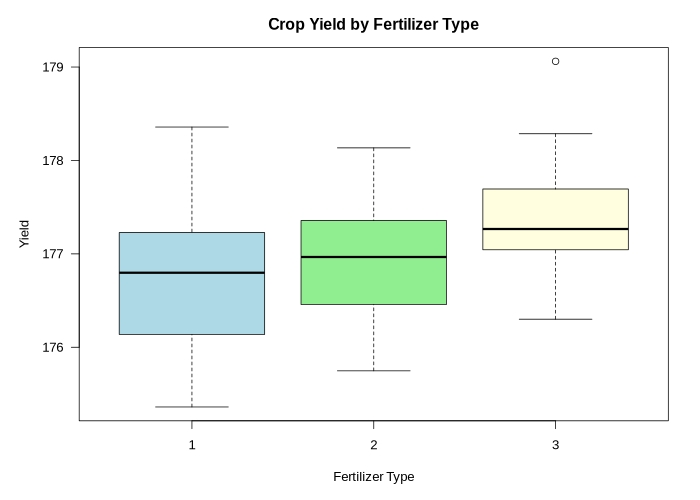

In [ ]:
# Visualize yield by fertilizer type
library(IRdisplay)

jpeg("/tmp/fertilizer_boxplot.jpg", width = 700, height = 500, quality = 100)
par(mar = c(5, 5, 3, 2), cex = 1.1)

boxplot(yield ~ fertilizer, data = crop.data,
        main = "Crop Yield by Fertilizer Type",
        xlab = "Fertilizer Type",
        ylab = "Yield",
        col = c("lightblue", "lightgreen", "lightyellow"),
        las = 1)

dev.off()
display_jpeg(file = "/tmp/fertilizer_boxplot.jpg")

### 📊 HOW TO INTERPRET THIS BOXPLOT

#### Anatomy of a Boxplot

```
                    ┌─── Maximum (excluding outliers)
                    │
         ─────┬─────┤     ← Upper Whisker
              │     │
         ┌────┴────┐│     ← Upper Quartile (Q3 = 75th percentile)
         │         ││
         │    ─────┼┤     ← MEDIAN (Q2 = 50th percentile)
         │         ││
         └────┬────┘│     ← Lower Quartile (Q1 = 25th percentile)
              │     │
         ─────┴─────┤     ← Lower Whisker
                    │
                    └─── Minimum (excluding outliers)

         ○  ← Outlier (point beyond 1.5 × IQR from quartiles)
```

#### 🔍 What to Look For in This Chart

**1. Compare MEDIANS (the middle lines)**
- Are the median lines at different heights across fertilizer types?
- Higher median = higher typical yield for that fertilizer
- If medians are at very different heights → likely significant difference

**2. Check for OVERLAP**
- Do the boxes overlap substantially?
- **Little overlap** → Groups are likely different (ANOVA will probably be significant)
- **Heavy overlap** → Groups may not be significantly different

**3. Compare SPREAD (box heights)**
- Are boxes similar heights? → Homogeneity of variance assumption likely met
- One box much taller? → Variance differs across groups (may violate assumption)

**4. Look for OUTLIERS (dots beyond whiskers)**
- Are there extreme values?
- Outliers can inflate variance and affect ANOVA results
- Consider investigating outliers before analysis

#### 🎯 Reading This Specific Plot

| Fertilizer | What to Observe |
|------------|-----------------|
| Type 1 | Note the median, box size, any outliers |
| Type 2 | Compare to Type 1 — higher/lower median? |
| Type 3 | Compare to both — which has highest median? |

**Before running ANOVA, make a prediction**: Based on this boxplot, do you expect ANOVA to be significant? Which fertilizers appear different?

#### 🏢 Business Insight from Visualization

> "Visual inspection suggests that [Fertilizer 3] may produce higher yields, as its median and box are positioned higher than the others. The boxes [do/do not] overlap substantially, suggesting [potential/minimal] significant differences. We'll confirm with ANOVA."

### One-Way ANOVA: Testing Fertilizer Effect

The `aov()` function in R performs Analysis of Variance.

**Formula syntax**: `DV ~ IV`
- Left side: Dependent variable (yield)
- Right side: Independent variable(s) (fertilizer)

**Interpreting the Output**:
| Component | Meaning |
|-----------|--------|
| **Df** | Degrees of freedom (groups - 1 for IV; total obs - groups for residuals) |
| **Sum Sq** | Sum of squares (variation between group means and overall mean) |
| **Mean Sq** | Sum of squares ÷ degrees of freedom |
| **F value** | Mean Sq(treatment) ÷ Mean Sq(residuals) — larger = more likely real effect |
| **Pr(>F)** | p-value — if < 0.05, reject null hypothesis |

In [ ]:
# One-way ANOVA: Does fertilizer type affect yield?
one.way <- aov(yield ~ fertilizer, data = crop.data)
summary(one.way)

            Df Sum Sq Mean Sq F value Pr(>F)    
fertilizer   2   6.07  3.0340   7.863  7e-04 ***
Residuals   93  35.89  0.3859                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### 📊 DETAILED INTERPRETATION GUIDE: One-Way ANOVA Output

#### Step-by-Step Guide to Reading ANOVA Output

When you run `summary(one.way)`, you'll see output similar to this (example values):

```
            Df Sum Sq Mean Sq F value   Pr(>F)    
fertilizer   2  6.07   3.035   4.846  0.0159 *  
Residuals   45 28.19   0.627                     
```

#### 🔍 Understanding Each Column

**1. Df (Degrees of Freedom)**
- **fertilizer Df = 2**: This equals (number of groups - 1). With 3 fertilizer types, Df = 3 - 1 = 2
- **Residuals Df = 45**: This equals (total observations - number of groups). With 48 observations and 3 groups, Df = 48 - 3 = 45
- **Why it matters**: Degrees of freedom affect the critical F-value needed for significance

**2. Sum Sq (Sum of Squares)**
- **fertilizer Sum Sq**: The variability in yield EXPLAINED by differences between fertilizer group means
- **Residuals Sum Sq**: The variability in yield NOT explained by fertilizer (random variation within groups)
- **Calculation**: Sum of squared differences from the mean
- **Business meaning**: Higher fertilizer Sum Sq = fertilizer explains more variation in crop yields

**3. Mean Sq (Mean Square)**
- **Formula**: Mean Sq = Sum Sq ÷ Df
- **fertilizer Mean Sq = 6.07 ÷ 2 = 3.035**
- **Residuals Mean Sq = 28.19 ÷ 45 = 0.627**
- **This is the "average" variance** attributed to each source

**4. F value (F-statistic)**
- **Formula**: F = Mean Sq (treatment) ÷ Mean Sq (residuals)
- **Example**: F = 3.035 ÷ 0.627 = 4.846
- **Interpretation**:
  - F ≈ 1: Between-group variance equals within-group variance (no real effect)
  - F > 1: Between-group variance exceeds within-group variance (possible real effect)
  - **The larger the F-value, the more evidence that groups are truly different**

**5. Pr(>F) (p-value)**
- **This is the probability of observing this F-value (or larger) if the null hypothesis were true**
- **Decision rule at α = 0.05**:
  - p < 0.05: **REJECT H₀** → Fertilizer types have significantly different effects on yield
  - p ≥ 0.05: **FAIL TO REJECT H₀** → No significant difference between fertilizer types

#### 🏢 Writing Your Business Conclusion

**Template for reporting ANOVA results**:

> "A one-way ANOVA was conducted to examine the effect of fertilizer type on crop yield. There was a statistically significant difference between fertilizer types, F(2, 45) = 4.85, p = .016. This indicates that at least one fertilizer produces significantly different yields compared to the others."

**Key elements to include**:
1. Test name (one-way ANOVA)
2. Variables (IV and DV)
3. F-statistic with degrees of freedom: F(df_treatment, df_residual)
4. p-value
5. Interpretation in plain language

#### ⚠️ Important Limitations

**ANOVA tells you IF there are differences, but NOT:**
- Which specific groups are different
- The direction of differences (which is higher/lower)
- The magnitude of the effect

**Next step**: Use Tukey's HSD post-hoc test to answer these questions!

### Interpreting One-Way ANOVA Results

**How to Read the Output**:

1. **Look at the p-value (Pr(>F))** for fertilizer:
   - If p < 0.05: Fertilizer type has a **statistically significant** effect on yield
   - If p ≥ 0.05: No significant difference between fertilizer types

2. **Look at the F-value**:
   - Larger F-values indicate greater between-group variance relative to within-group variance
   - F ≈ 1 suggests no real difference; F >> 1 suggests real differences

3. **Look at the Sum of Squares**:
   - Fertilizer Sum Sq / Total Sum Sq = proportion of variance explained

**Business Interpretation**: If significant, the choice of fertilizer matters for crop yield — a real cost/benefit decision for the farm.

---

## Two-Way ANOVA: Adding Planting Density

### When to Use Two-Way ANOVA

Use two-way ANOVA when you want to examine:
1. The effect of **two categorical independent variables** on a continuous DV
2. The **interaction** between the two IVs

**Business Question**: Do BOTH fertilizer type AND planting density affect crop yield?

### The Three Hypotheses in Two-Way ANOVA

| Hypothesis Set | H₀ | H₁ |
|----------------|-----|----|
| **Main Effect 1** | All fertilizer means are equal | At least one fertilizer mean differs |
| **Main Effect 2** | All density means are equal | At least one density mean differs |
| **Interaction** | No interaction between fertilizer and density | Interaction exists |

In [ ]:
# Two-way ANOVA: Main effects of fertilizer AND density
two.way <- aov(yield ~ fertilizer + density, data = crop.data)
summary(two.way)

            Df Sum Sq Mean Sq F value   Pr(>F)    
fertilizer   2  6.068   3.034   9.073 0.000253 ***
density      1  5.122   5.122  15.316 0.000174 ***
Residuals   92 30.765   0.334                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### 📊 DETAILED INTERPRETATION GUIDE: Two-Way ANOVA Output

#### Understanding the Two-Way ANOVA Table

Your output will look something like this:

```
            Df Sum Sq Mean Sq F value   Pr(>F)    
fertilizer   2  6.07   3.035   6.073  0.00489 ** 
density      1  5.12   5.122  10.244  0.00263 ** 
Residuals   44 22.00   0.500                     
```

#### 🔍 Row-by-Row Interpretation

**Row 1: fertilizer**
- Tests: "Are fertilizer group means different, HOLDING DENSITY CONSTANT?"
- If p < 0.05: Fertilizer type has a significant main effect on yield
- This is the same hypothesis as one-way ANOVA, but now **controlled for density**

**Row 2: density**
- Tests: "Are density group means different, HOLDING FERTILIZER CONSTANT?"
- If p < 0.05: Planting density has a significant main effect on yield
- This is a NEW finding beyond the one-way ANOVA

**Row 3: Residuals**
- The unexplained (random) variation
- **Compare to one-way ANOVA**: Residual Sum Sq should be SMALLER now
- Why? Because density explains some of the variation that was previously "unexplained"

#### 📈 Comparing One-Way vs. Two-Way ANOVA

| Metric | One-Way | Two-Way | Interpretation |
|--------|---------|---------|----------------|
| Residual Sum Sq | 28.19 | 22.00 | Two-way explains more variance |
| Residual Mean Sq | 0.627 | 0.500 | Less unexplained variance per observation |
| F-value (fertilizer) | 4.85 | 6.07 | More powerful test with less error variance |
| p-value (fertilizer) | 0.016 | 0.005 | More significant with better model |

#### 🏢 Business Insight: Why Add Variables?

Adding planting density to our model:
1. **Increases power**: By explaining more variance, we can detect smaller effects
2. **Reduces error**: Our fertilizer estimate is more precise
3. **Provides new information**: We now know density ALSO matters
4. **Enables better recommendations**: "Use fertilizer X at density Y"

#### ✍️ Writing Your Two-Way ANOVA Results

> "A two-way ANOVA was conducted to examine the effects of fertilizer type and planting density on crop yield. Both main effects were statistically significant. Fertilizer type had a significant effect, F(2, 44) = 6.07, p = .005, as did planting density, F(1, 44) = 10.24, p = .003. The two-way model explained more variance than fertilizer alone (residual SS reduced from 28.19 to 22.00)."

### Interpreting Two-Way ANOVA Results

**Compare to One-Way ANOVA**:
- Did adding density **reduce the residual variance** (residual Sum Sq)?
- Is density also **statistically significant** (p < 0.05)?

If both are significant, the model is improved — we've explained more variance in yield.

**Key Insight**: Adding planting density might reduce residual variance, meaning both factors contribute to explaining yield variation.

---

### Testing for Interaction Effects

**What is an Interaction?**

An interaction occurs when the effect of one variable **depends on the level of another variable**.

**Business Example**: 
- Fertilizer 3 might work great at low density but poorly at high density
- The "best" fertilizer might depend on how densely plants are planted

**Formula syntax**: `yield ~ fertilizer * density` (the `*` includes main effects AND interaction)

In [ ]:
# Two-way ANOVA with interaction
twoway_interaction <- aov(yield ~ fertilizer * density, data = crop.data)
summary(twoway_interaction)

                   Df Sum Sq Mean Sq F value   Pr(>F)    
fertilizer          2  6.068   3.034   9.001 0.000273 ***
density             1  5.122   5.122  15.195 0.000186 ***
fertilizer:density  2  0.428   0.214   0.635 0.532500    
Residuals          90 30.337   0.337                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### 📊 DETAILED INTERPRETATION GUIDE: Interaction Effects

#### Understanding the Interaction Term

Your output will include a new row for the interaction:

```
                  Df Sum Sq Mean Sq F value   Pr(>F)    
fertilizer         2  6.07   3.035   6.073  0.00489 ** 
density            1  5.12   5.122  10.244  0.00263 ** 
fertilizer:density 2  0.43   0.214   0.428  0.65482    
Residuals         42 21.00   0.500                     
```

#### 🔍 What Does the Interaction Row Mean?

**fertilizer:density** tests: "Does the effect of fertilizer DEPEND ON the level of density?"

| p-value | Interpretation | Business Implication |
|---------|----------------|----------------------|
| p < 0.05 | **Significant interaction** | The "best" fertilizer changes depending on density |
| p ≥ 0.05 | **No significant interaction** | The "best" fertilizer is the same regardless of density |

#### 🎯 Why Interactions Matter: A Concrete Example

**Scenario WITHOUT interaction** (p ≥ 0.05):
- Fertilizer 3 is best at low density: yields 180 bushels
- Fertilizer 3 is best at high density: yields 200 bushels
- **Conclusion**: "Always use Fertilizer 3"

**Scenario WITH interaction** (p < 0.05):
- At LOW density: Fertilizer 3 yields 200, Fertilizer 1 yields 150
- At HIGH density: Fertilizer 1 yields 210, Fertilizer 3 yields 160
- **Conclusion**: "Use Fertilizer 3 at low density, Fertilizer 1 at high density"

#### 📊 Visualizing Interactions

When you have a significant interaction:
- Plot lines for each fertilizer across density levels
- **Parallel lines** = No interaction (effects are additive)
- **Crossing or diverging lines** = Interaction present (effects depend on each other)

```
YIELD                           YIELD
  |    ___Fert3                   |      ___Fert1
  |   ___Fert2                    |    /   \___
  |  ___Fert1                     |   /   Fert3
  |___________ DENSITY            |___________ DENSITY
   Low    High                     Low    High
   
   NO INTERACTION                 INTERACTION PRESENT
   (parallel lines)               (crossing lines)
```

#### ✍️ Reporting Interaction Results

**If interaction is NOT significant**:
> "There was no significant interaction between fertilizer type and planting density, F(2, 42) = 0.43, p = .655. Therefore, the main effects can be interpreted independently: fertilizer and density each have their own effect on yield that does not depend on the other."

**If interaction IS significant**:
> "There was a significant interaction between fertilizer type and planting density, F(2, 42) = 4.85, p = .013. This indicates that the effect of fertilizer on yield depends on the planting density. Simple effects analysis is needed to understand the nature of this interaction."

### Interpreting Interaction Results

Look at the `fertilizer:density` row:
- **p < 0.05**: Significant interaction — the effect of fertilizer depends on density
- **p ≥ 0.05**: No significant interaction — main effects can be interpreted independently

**If NO interaction**: You can say "Fertilizer X is best" regardless of density.

**If interaction EXISTS**: You must qualify your recommendation: "Fertilizer X is best WHEN density is low."

---

### Adding Blocking Variables

**What is Blocking?**

A blocking variable accounts for known sources of variability that aren't of primary interest:
- Different experimental plots (blocks)
- Different time periods
- Different technicians

By including blocks, we can **reduce residual variance** and increase power to detect real effects.

In [ ]:
# ANOVA with blocking
blocking <- aov(yield ~ fertilizer + density + block, data = crop.data)
summary(blocking)

            Df Sum Sq Mean Sq F value   Pr(>F)    
fertilizer   2  6.068   3.034   9.018 0.000269 ***
density      1  5.122   5.122  15.224 0.000184 ***
block        2  0.486   0.243   0.723 0.488329    
Residuals   90 30.278   0.336                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Model Comparison: Which ANOVA Model is Best?

When we have multiple candidate models, we can compare them using **information criteria**:

| Criterion | What It Measures | How to Use |
|-----------|-----------------|------------|
| **AIC** (Akaike Information Criterion) | Model fit penalized for complexity | Lower is better |
| **BIC** (Bayesian Information Criterion) | Similar to AIC, stronger penalty | Lower is better |
| **AICc Weight** | Probability this is the best model | Higher is better |

The `aictab()` function compares all models at once.

In [ ]:
# Compare all models
model.set <- list(one.way, two.way, twoway_interaction, blocking)
model.names <- c("one.way", "two.way", "twoway_interaction", "blocking")

aictab(model.set, modnames = model.names)

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,two.way,5,173.8562,0.000000,1.000000000,0.70804078,-81.59474,0.7080408
4,blocking,7,176.9331,3.076961,0.214707131,0.15202140,-80.83019,0.8600622
3,twoway_interaction,7,177.1178,3.261693,0.195763768,0.13860873,-80.92256,0.9986709
1,one.way,4,186.4122,12.556015,0.001877137,0.00132909,-88.98630,1.0000000


### 📊 DETAILED INTERPRETATION GUIDE: Model Comparison with AIC

#### Understanding the AIC Table Output

Your `aictab()` output will look like this:

```
Model selection based on AICc:

                    K   AICc Delta_AICc AICcWt Cum.Wt      LL
two.way             5  95.23       0.00   0.67   0.67  -41.76
blocking            7  98.10       2.87   0.16   0.83  -40.40
twoway_interaction  7  99.45       4.22   0.08   0.91  -41.08
one.way             4 101.22       5.99   0.03   0.94  -45.34
```

#### 🔍 Understanding Each Column

**K (Number of Parameters)**
- Counts how many parameters the model estimates
- More complex models have higher K
- Example: one.way (4) vs twoway_interaction (7)

**AICc (Corrected AIC)**
- AIC adjusted for sample size
- **LOWER values = BETTER model fit** (relative to complexity)
- Balances goodness-of-fit against overfitting

**Delta_AICc**
- Difference from the best model (which has Delta = 0)
- **Rules of thumb**:
  - Δ = 0-2: Model has substantial support (essentially equivalent)
  - Δ = 2-7: Model has considerably less support
  - Δ > 10: Model has essentially no support

**AICcWt (Akaike Weight)**
- **Probability that this is the best model** given the candidate set
- All weights sum to 1.0
- Higher weight = more evidence this is the best model

**Cum.Wt (Cumulative Weight)**
- Running sum of weights
- Helps identify "confidence set" of best models

**LL (Log-Likelihood)**
- Higher values indicate better fit
- But doesn't account for model complexity (AIC does)

#### 🏢 Making Business Decisions with AIC

**In the example above**:
1. **two.way** is the best model (lowest AICc, highest weight = 67%)
2. **blocking** is close (Δ = 2.87, weight = 16%)
3. Combined, these two models have 83% of the weight → strong evidence for considering both

**Decision Framework**:
| Scenario | Decision |
|----------|----------|
| One model has weight > 90% | Use that model |
| 2-3 models have similar weights | Consider model averaging or choose simpler |
| Best model is much more complex | Consider if added complexity is worth it |

#### ✍️ Reporting Model Comparison

> "Model comparison using AIC indicated that the two-way ANOVA (fertilizer + density) was the best-fitting model, receiving 67% of the Akaike weight (AICc = 95.23). The blocking model also received some support (16% weight). The interaction model and one-way ANOVA received minimal support (< 10% combined). Based on this analysis, we conclude that a model including both fertilizer and density main effects (without interaction) provides the best balance of fit and parsimony."

### Interpreting Model Comparison

**How to Read the AIC Table**:

1. **K**: Number of parameters in the model
2. **AICc**: Corrected AIC (adjusted for sample size)
3. **Delta_AICc**: Difference from best model (best = 0)
4. **AICcWt**: Weight/probability of being best model
5. **Cum.Wt**: Cumulative weight
6. **LL**: Log-likelihood

**Decision Rule**:
- Model with **lowest AICc** is preferred
- Models within 2 AICc units are essentially equivalent
- Models with Delta > 10 have essentially no support

---

## Post-Hoc Analysis: Which Groups Are Different?

### The Limitation of ANOVA

ANOVA tells us **IF** there are differences among groups, but not **WHICH** groups differ.

**Tukey's Honestly Significant Difference (HSD)** test performs pairwise comparisons while controlling for familywise error rate.

### Interpreting Tukey's HSD

| Output Column | Meaning |
|---------------|--------|
| **diff** | Difference between group means |
| **lwr** | Lower bound of 95% confidence interval |
| **upr** | Upper bound of 95% confidence interval |
| **p adj** | Adjusted p-value (if < 0.05, groups are significantly different) |

**Key Insight**: If the confidence interval **does NOT contain zero**, the groups are significantly different.

In [ ]:
# Tukey's HSD for the best model (two-way ANOVA)
tukey.two.way <- TukeyHSD(two.way)
tukey.two.way

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = yield ~ fertilizer + density, data = crop.data)

$fertilizer
         diff         lwr       upr     p adj
2-1 0.1761687 -0.16822506 0.5205625 0.4452958
3-1 0.5991256  0.25473179 0.9435194 0.0002219
3-2 0.4229569  0.07856306 0.7673506 0.0119381

$density
        diff       lwr       upr     p adj
2-1 0.461956 0.2275204 0.6963916 0.0001741


### 📊 DETAILED INTERPRETATION GUIDE: Tukey's HSD Post-Hoc Test

#### Understanding Tukey's HSD Output

Your `TukeyHSD()` output will look like this:

```
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = yield ~ fertilizer + density, data = crop.data)

$fertilizer
        diff        lwr       upr     p adj
2-1  0.1750000 -0.4774652 0.8274652 0.7931947
3-1  0.8500000  0.1975348 1.5024652 0.0083186
3-2  0.6750000  0.0225348 1.3274652 0.0414927

$density
       diff       lwr       upr     p adj
2-1 0.56375 0.1164888 1.0110112 0.0150093
```

#### 🔍 Understanding Each Column

**diff (Difference)**
- The difference between the two group means
- Example: `3-1 = 0.85` means Fertilizer 3's average yield is 0.85 units HIGHER than Fertilizer 1

**lwr and upr (Lower and Upper CI Bounds)**
- 95% confidence interval for the true difference
- **KEY RULE**: If the interval **crosses zero**, the difference is NOT significant
- If the interval **does NOT cross zero**, the difference IS significant

**p adj (Adjusted p-value)**
- p-value adjusted for multiple comparisons (controls familywise error)
- If p adj < 0.05: The groups are significantly different

#### 📊 Reading Each Comparison

| Comparison | diff | CI Contains Zero? | p adj | Conclusion |
|------------|------|-------------------|-------|------------|
| 2-1 | 0.175 | YES (-0.48 to 0.83) | 0.793 | NOT different |
| 3-1 | 0.850 | NO (0.20 to 1.50) | 0.008 | SIGNIFICANTLY different |
| 3-2 | 0.675 | NO (0.02 to 1.33) | 0.041 | SIGNIFICANTLY different |

#### 🏢 Translating to Business Recommendations

Based on the example above:

**Statistical Findings**:
1. Fertilizers 1 and 2 are NOT significantly different (p = 0.79)
2. Fertilizer 3 is significantly BETTER than Fertilizer 1 (diff = +0.85, p = 0.008)
3. Fertilizer 3 is significantly BETTER than Fertilizer 2 (diff = +0.68, p = 0.041)

**Business Recommendation**:
> "Fertilizer 3 produces significantly higher crop yields than both Fertilizers 1 and 2. We recommend using Fertilizer 3 for maximum yield. If cost is a concern, note that Fertilizers 1 and 2 are statistically equivalent — choose the cheaper option if Fertilizer 3 is not feasible."

#### ✍️ Formal Reporting of Post-Hoc Results

> "Tukey's HSD post-hoc comparisons revealed that Fertilizer 3 produced significantly higher yields than Fertilizer 1 (mean difference = 0.85, 95% CI [0.20, 1.50], p = .008) and Fertilizer 2 (mean difference = 0.68, 95% CI [0.02, 1.33], p = .041). Fertilizers 1 and 2 did not differ significantly from each other (mean difference = 0.18, 95% CI [-0.48, 0.83], p = .793)."

#### 🎯 Quick Reference: Reading Tukey's Output

| Check This | Look For | Conclusion |
|------------|----------|------------|
| Confidence interval | Does NOT cross zero | Groups are significantly different |
| Confidence interval | Crosses zero | Groups are NOT significantly different |
| p adj | < 0.05 | Significant difference |
| diff sign | Positive | First group listed has LOWER mean |
| diff sign | Negative | First group listed has HIGHER mean |

### Visualizing Tukey's HSD Results

The plot shows confidence intervals for each pairwise comparison:
- Intervals that **cross zero** = NOT significantly different
- Intervals that **do NOT cross zero** = Significantly different

agg_record_702041211 
                   2

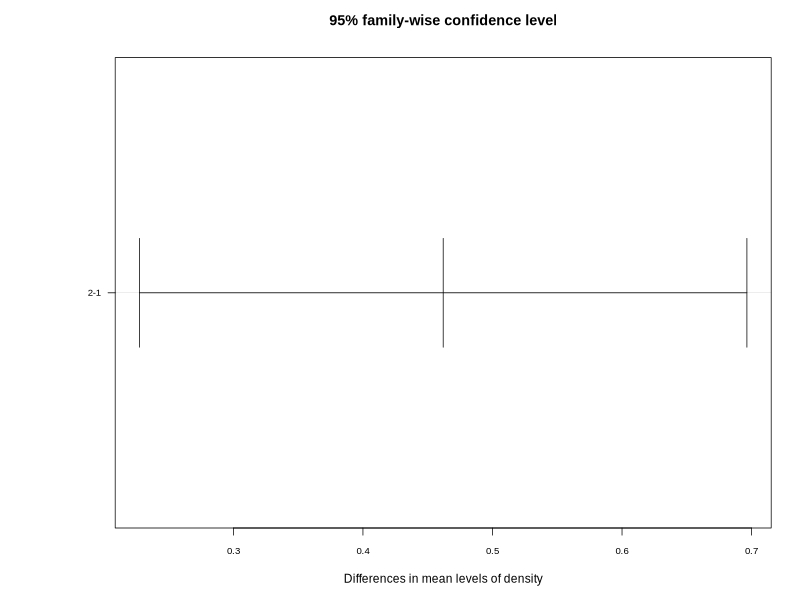

In [ ]:
# Plot Tukey results
library(IRdisplay)

jpeg("/tmp/tukey_plot.jpg", width = 800, height = 600, quality = 100)
par(mar = c(5, 8, 4, 2))
plot(tukey.two.way, las = 1, cex.axis = 0.8)
dev.off()

display_jpeg(file = "/tmp/tukey_plot.jpg")

### 📊 HOW TO INTERPRET THE TUKEY HSD PLOT

#### Anatomy of the Tukey Plot

**Important**: In R's default Tukey plot, there is **NO dot or marker** for the point estimate. The point estimate (mean difference) is simply the **CENTER of the horizontal line**.

```
                         Zero Line (dashed vertical line)
                              │
                              │
    3-1  ├────────────────────│───────┤    
                    ↑         │
              CENTER of line  │         ← This is the point estimate (mean diff)
              = mean diff     │
                              │
    2-1  ├────────────────────┼────────────┤     ← Line CROSSES zero = NOT significant
                              │
                              │
    3-2  ├─────────────────┤  │         ← Entire line is LEFT of zero = SIGNIFICANT
                              │
                              │
    
    ┌─────────────────────────────────────────────────────────────┐
    │  KEY:                                                        │
    │  ├──────────────┤  = The horizontal line IS the CI          │
    │                                                              │
    │  CENTER of line  = Point estimate (mean difference)         │
    │                    (There is NO separate dot marker!)        │
    │                                                              │
    │  LEFT end (├)    = Lower bound of 95% CI                    │
    │  RIGHT end (┤)   = Upper bound of 95% CI                    │
    │                                                              │
    │  Dashed │ line   = Zero (no difference)                     │
    └─────────────────────────────────────────────────────────────┘
```

#### 🔍 Finding the Point Estimate (Mean Difference)

Since there's no marker, here's how to find it:

1. **Look at the horizontal line** for each comparison
2. **Find the midpoint** (center) of that line
3. **That center point IS your mean difference estimate**
4. **Read the x-axis value** at that center point to get the numeric estimate

**Or easier**: Just look at the `TukeyHSD()` table output — the `diff` column gives you the exact value!

#### 🎯 The ONE Rule You Need

**Look at each horizontal line (confidence interval):**
- **Does it cross the dashed zero line?**
  - **NO** → The two groups ARE significantly different ✓
  - **YES** → The two groups are NOT significantly different ✗

#### 📊 Reading Each Comparison

| Row Label | Meaning | How to Read |
|-----------|---------|-------------|
| 2-1 | Fertilizer 2 minus Fertilizer 1 | If line is right of zero → Fert 2 > Fert 1 |
| 3-1 | Fertilizer 3 minus Fertilizer 1 | If line is right of zero → Fert 3 > Fert 1 |
| 3-2 | Fertilizer 3 minus Fertilizer 2 | If line is right of zero → Fert 3 > Fert 2 |

#### 🎯 Step-by-Step Interpretation

**Step 1**: Locate the dashed zero line (vertical line at x = 0)

**Step 2**: For each horizontal line:
- **Entire line RIGHT of zero** → Second group has HIGHER mean (significant)
- **Entire line LEFT of zero** → First group has HIGHER mean (significant)  
- **Line CROSSES zero** → No significant difference

**Step 3**: Estimate the effect size
- The CENTER of the line = mean difference
- Further from zero = larger difference between groups
- Check the x-axis scale for the numeric value

#### 📋 Cross-Reference with the Table

The Tukey plot visualizes exactly what's in the `TukeyHSD()` table:

| Plot Element | Table Column |
|--------------|--------------|
| Center of line | `diff` (mean difference) |
| Left end of line | `lwr` (lower CI bound) |
| Right end of line | `upr` (upper CI bound) |
| Line crosses zero? | `p adj` < 0.05 means it doesn't |

**Pro tip**: Use the plot for quick visual assessment, then refer to the table for exact numbers.

#### 🏢 Writing Your Interpretation

**Example for a significant comparison (line doesn't cross zero)**:
> "The confidence interval for the 3-1 comparison lies entirely to the right of zero, indicating that Fertilizer 3 produces significantly higher yields than Fertilizer 1. The estimated difference is approximately [read center of line from x-axis] units."

**Example for a non-significant comparison (line crosses zero)**:
> "The confidence interval for the 2-1 comparison crosses zero, indicating no statistically significant difference between Fertilizers 1 and 2."

#### ⚠️ Common Confusion

| What You See | What It Means |
|--------------|---------------|
| "Where's the dot?" | There is no dot — the CENTER of the line is the estimate |
| Long line | Wide confidence interval (less precise estimate) |
| Short line | Narrow confidence interval (more precise estimate) |
| Line touching zero | Borderline case — check p-value in table |

### Business Decision from Post-Hoc Analysis

Based on Tukey's HSD results:
- Which fertilizer(s) produce significantly **higher** yields?
- Which fertilizer(s) are **not different** from each other (potential cost savings)?
- What **recommendation** would you make to the farm manager?

**Example Interpretation**:
> "Fertilizer 3 produces significantly higher yields than Fertilizers 1 and 2 (p < 0.05). Fertilizers 1 and 2 are not significantly different from each other. We recommend using Fertilizer 3, unless cost considerations favor the statistically equivalent Fertilizers 1 or 2."

---

## ANOVA Exercise: Customer Retention

### Business Problem

A company wants to know if **income level** (Low/High) and **asset value** (Low/High) affect **customer retention probability**.

This is a **two-way ANOVA** problem with:
- DV: Retention probability (continuous)
- IV1: Income level (categorical: Low/High)
- IV2: Asset value (categorical: Low/High)

In [ ]:
# Load customer retention data
retention_data <- read.csv("Session 2-ANOVA-EXCERCISE Customer Retention.csv", header = TRUE)

# Clean column names (remove spaces)
colnames(retention_data) <- c("Retention_Prob", "Asset_Value", "Income")

# View structure
str(retention_data)

'data.frame':	32 obs. of  3 variables:
 $ Retention_Prob: num  0.309 0.156 0.134 0.241 0.203 ...
 $ Asset_Value   : chr  "Low" "Low" "Low" "Low" ...
 $ Income        : chr  "High" "High" "High" "High" ...


In [ ]:
# Summary
summary(retention_data)

 Retention_Prob   Asset_Value           Income         
 Min.   :0.0532   Length:32          Length:32         
 1st Qu.:0.2610   Class :character   Class :character  
 Median :0.7174   Mode  :character   Mode  :character  
 Mean   :0.6366                                        
 3rd Qu.:0.9547                                        
 Max.   :0.9923                                        

In [ ]:
# Two-way ANOVA for customer retention
retention_anova <- aov(Retention_Prob ~ Income * Asset_Value, data = retention_data)
summary(retention_anova)

                   Df Sum Sq Mean Sq F value   Pr(>F)    
Income              1 0.0539  0.0539   1.104 0.302463    
Asset_Value         1 0.9203  0.9203  18.858 0.000167 ***
Income:Asset_Value  1 1.2623  1.2623  25.866 2.19e-05 ***
Residuals          28 1.3665  0.0488                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
# Post-hoc if significant
TukeyHSD(retention_anova)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Retention_Prob ~ Income * Asset_Value, data = retention_data)

$Income
            diff         lwr       upr     p adj
Low-High 0.08205 -0.07793941 0.2420394 0.3024627

$Asset_Value
              diff        lwr        upr     p adj
Low-High -0.339175 -0.4991644 -0.1791856 0.0001667

$`Income:Asset_Value`
                        diff        lwr         upr     p adj
Low:High-High:High -0.315175 -0.6167547 -0.01359526 0.0379970
High:Low-High:High -0.736400 -1.0379797 -0.43482026 0.0000018
Low:Low-High:High  -0.257125 -0.5587047  0.04445474 0.1157662
High:Low-Low:High  -0.421225 -0.7228047 -0.11964526 0.0036462
Low:Low-Low:High    0.058050 -0.2435297  0.35962974 0.9521887
Low:Low-High:Low    0.479275  0.1776953  0.78085474 0.0009174


---

## Part 2: Multivariate Analysis of Variance (MANOVA)

### When ANOVA Isn't Enough

**MANOVA** extends ANOVA to situations with **multiple dependent variables**.

| Aspect | ANOVA | MANOVA |
|--------|-------|--------|
| Number of DVs | 1 | 2 or more |
| Test statistic | F-test | Pillai's Trace, Wilks' Lambda, etc. |
| Accounts for DV correlations | N/A | Yes |
| Type | Parametric | Non-parametric |

### Why Use MANOVA Instead of Multiple ANOVAs?

1. **Controls Type I error**: Multiple ANOVAs inflate error rate
2. **Captures relationships between DVs**: Uses covariance structure
3. **More powerful**: Can detect effects that individual ANOVAs miss
4. **More realistic**: Business outcomes are often correlated

### Business Scenario: Regional Product Launch

> Flybig Inc. launched a new product across four regions (A, B, C, D). They want to understand if regions are associated with different levels of:
> 1. New product penetration (%)
> 2. Profit (%)
>
> **Key insight**: Penetration and profit are likely correlated — regions that sell more might also be more profitable.

---

### MANOVA Assumptions

MANOVA has stricter assumptions than ANOVA:

| Assumption | Test | What to Look For |
|------------|------|------------------|
| **Multivariate Normality** | Shapiro-Wilk (univariate), Mardia's test | p > 0.05 |
| **Homogeneity of Covariance Matrices** | Box's M test | p > 0.001 |
| **Linearity** | Scatterplots | Linear relationships |
| **No Multicollinearity** | Correlation matrix | DVs shouldn't be TOO highly correlated |
| **No Outliers** | Boxplots, Mahalanobis distance | Inspect and potentially remove |

### MANOVA Hypotheses

**H₀**: Group mean vectors are the same across all groups
$$H_0: \boldsymbol{\mu}_A = \boldsymbol{\mu}_B = \boldsymbol{\mu}_C = \boldsymbol{\mu}_D$$

**H₁**: At least one group mean vector is different

In [ ]:
# Load MANOVA data
manova_data <- read.csv("Session 2 MANOVA R  manova_data.csv", header = TRUE)

# View structure
str(manova_data)

'data.frame':	40 obs. of  3 variables:
 $ regions                : chr  "A" "A" "A" "A" ...
 $ new_product_penetration: num  20 22 24 18 20 20 16 17 18 14 ...
 $ profit                 : num  0.7 0.8 0.95 0.6 0.74 0.76 0.84 0.66 0.99 0.8 ...


In [ ]:
# Summary statistics by region
manova_data %>% 
  group_by(regions) %>% 
  summarise(
    n = n(),
    mean_penetration = mean(new_product_penetration),
    sd_penetration = sd(new_product_penetration),
    mean_profit = mean(profit),
    sd_profit = sd(profit)
  )

regions,n,mean_penetration,sd_penetration,mean_profit,sd_profit
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
A,10,18.90,2.923088,0.784,0.12130769
B,10,16.54,1.920185,0.608,0.09681598
C,10,3.05,1.039498,0.272,0.14327906
D,10,9.35,2.106735,0.474,0.09453982


### Visualizing MANOVA Data

Before analysis, visualize both dependent variables by region:


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




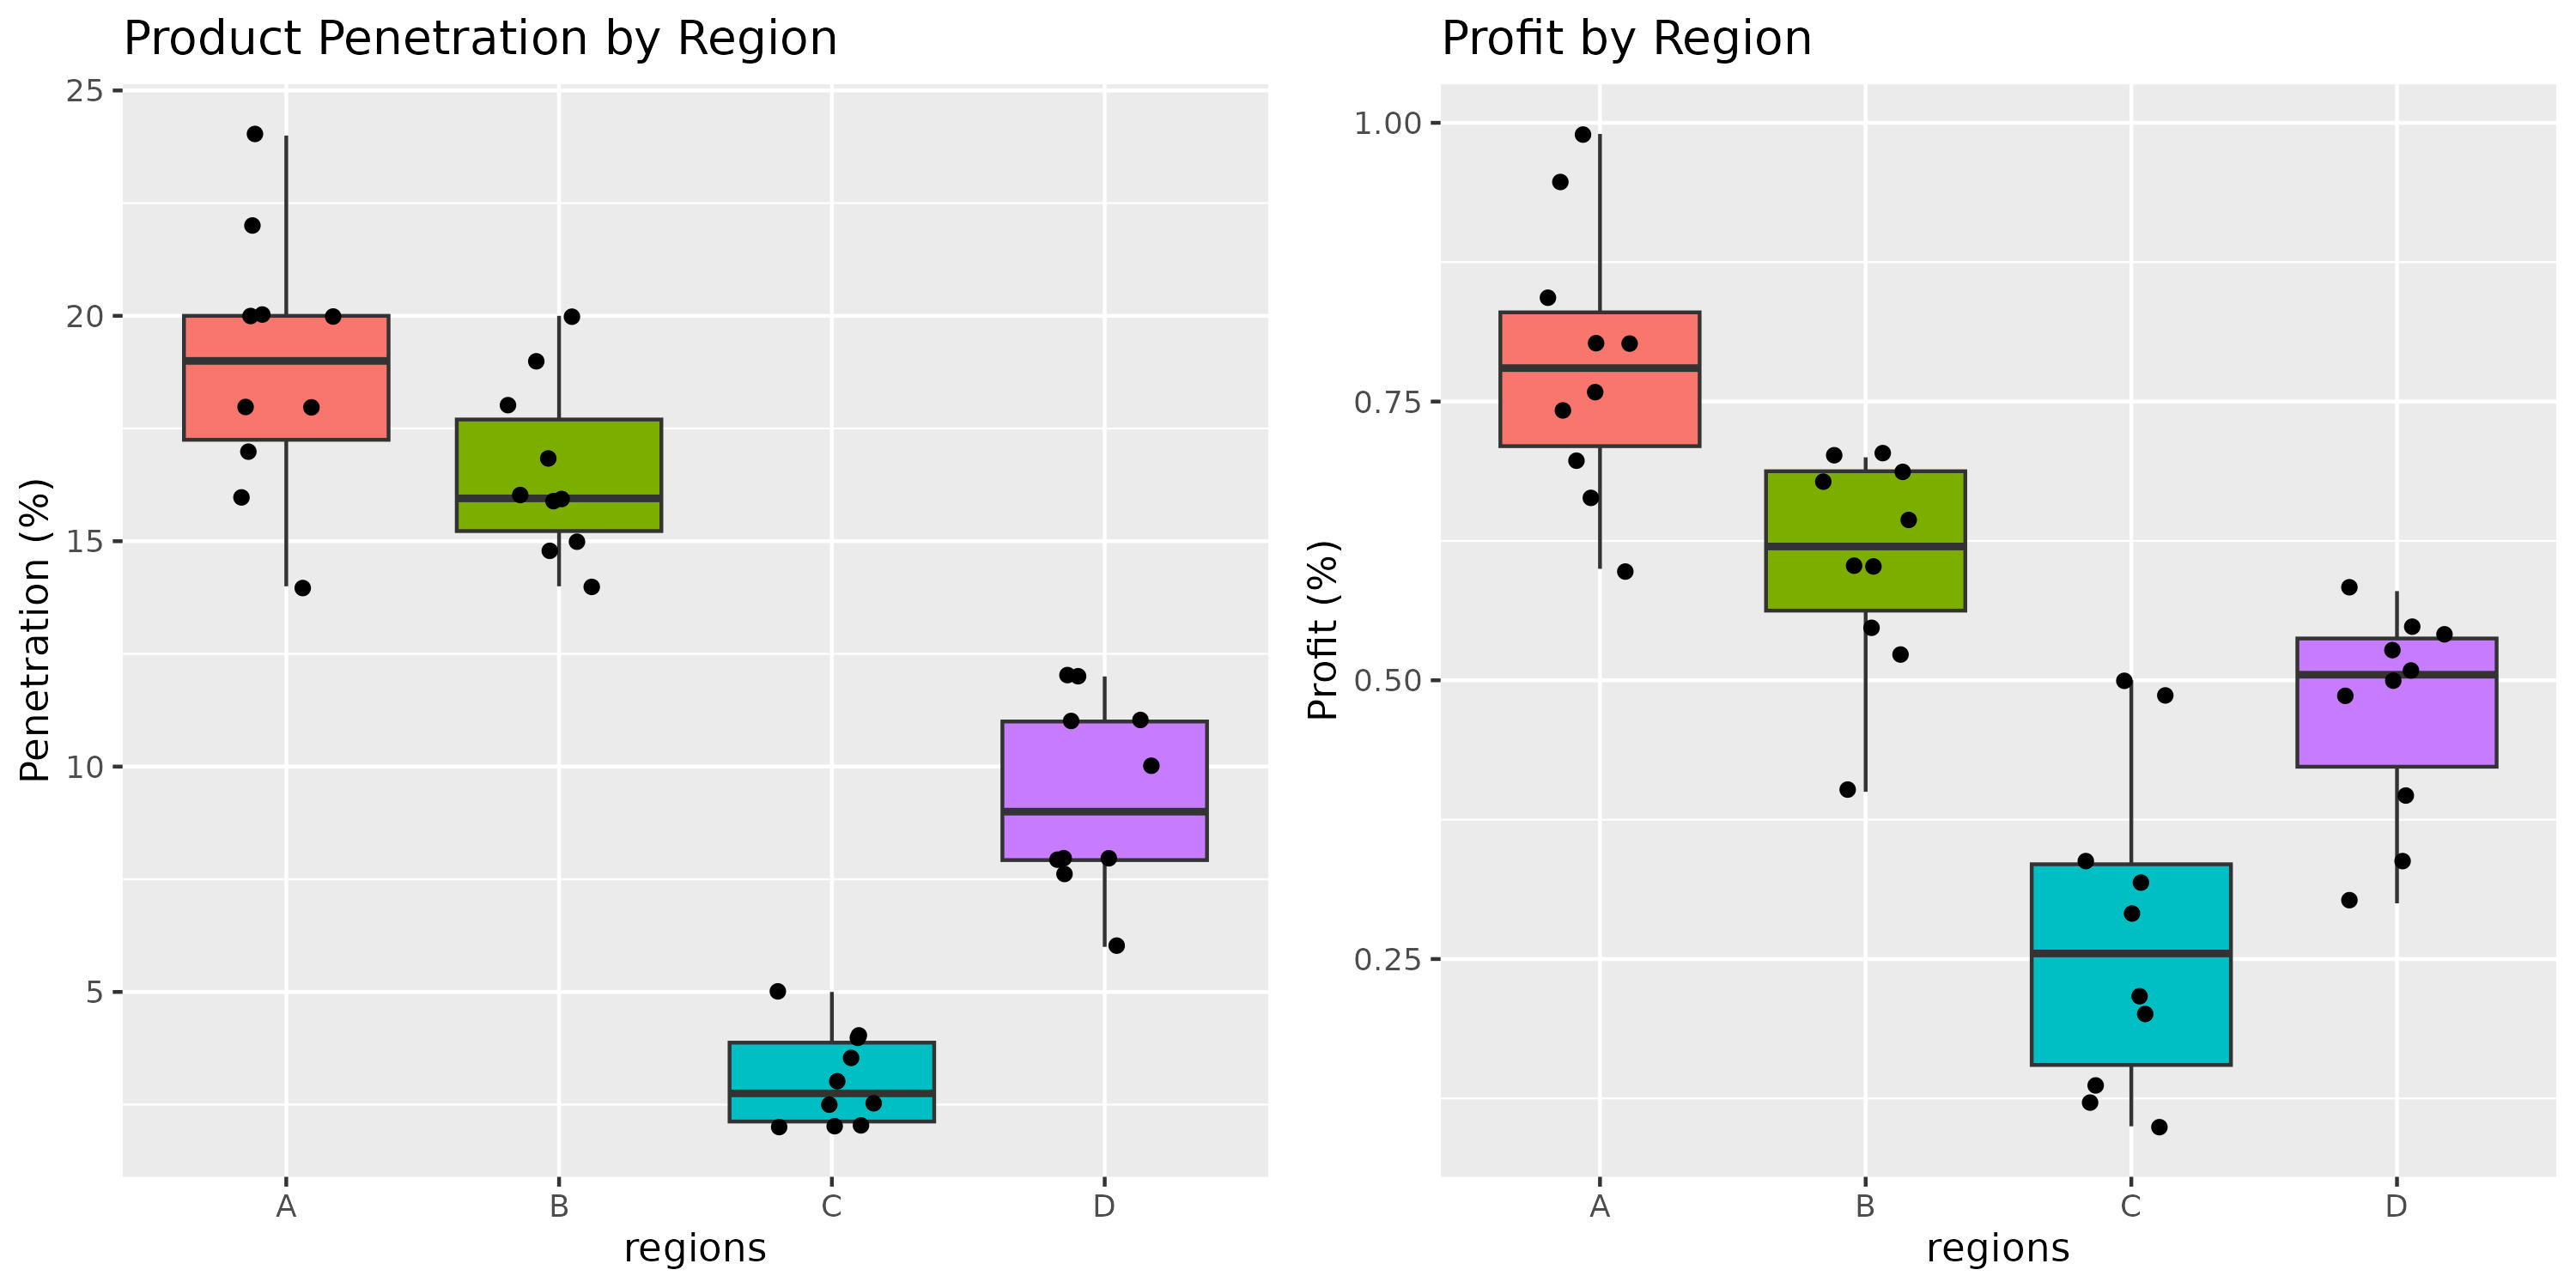

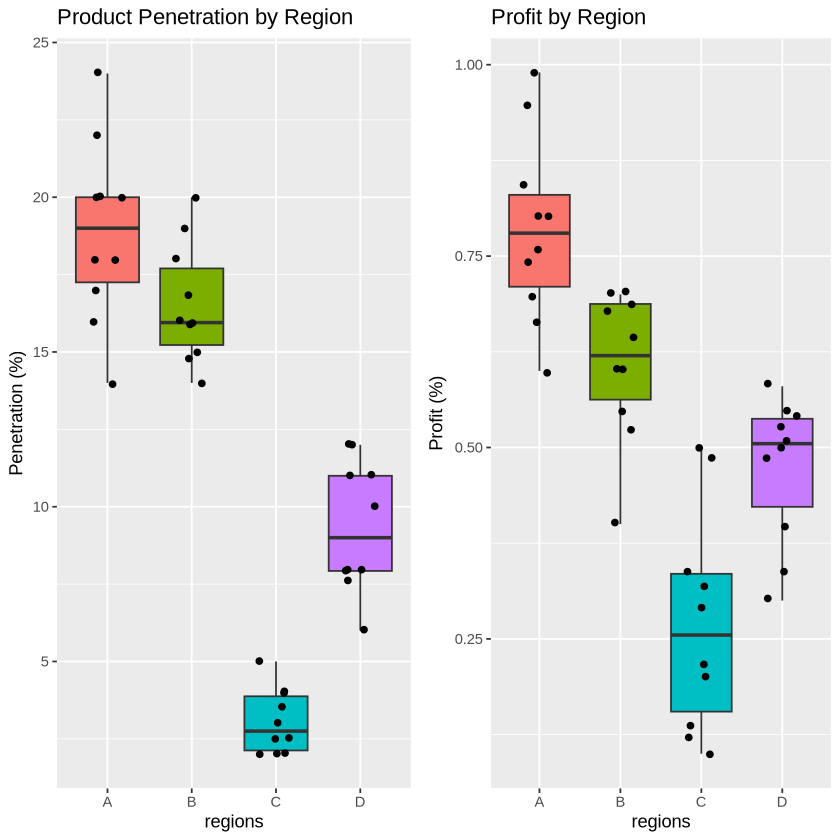

In [ ]:
# Visualization of both DVs by region
library(IRdisplay)
library(gridExtra)

p1 <- ggplot(manova_data, aes(x = regions, y = new_product_penetration, fill = regions)) + 
  geom_boxplot(outlier.shape = NA) + 
  geom_jitter(width = 0.2) + 
  labs(title = "Product Penetration by Region", y = "Penetration (%)") +
  theme(legend.position = "none")

p2 <- ggplot(manova_data, aes(x = regions, y = profit, fill = regions)) + 
  geom_boxplot(outlier.shape = NA) + 
  geom_jitter(width = 0.2) + 
  labs(title = "Profit by Region", y = "Profit (%)") +
  theme(legend.position = "none")

combined_plot <- grid.arrange(p1, p2, ncol = 2)

# Save and display
ggsave("/tmp/manova_boxplots.jpg", combined_plot, width = 10, height = 5)
display_jpeg(file = "/tmp/manova_boxplots.jpg")

### 📊 HOW TO INTERPRET SIDE-BY-SIDE BOXPLOTS (MANOVA Visualization)

#### Why Two Boxplots?

In MANOVA, we have **multiple dependent variables**. We visualize each DV separately to understand:
1. How each outcome varies by group
2. Whether the same groups perform well (or poorly) on both outcomes

#### 🔍 Reading the LEFT Plot (Product Penetration by Region)

**Questions to answer:**
- Which region(s) have the highest median penetration?
- Which region(s) have the most variability (tallest boxes)?
- Are there outliers that might affect results?
- Do boxes overlap substantially across regions?

#### 🔍 Reading the RIGHT Plot (Profit by Region)

**Same questions for profit:**
- Which region(s) have the highest median profit?
- Is the ranking of regions the SAME as for penetration?
- Do high-penetration regions also have high profit?

#### 🎯 The MANOVA Connection

**Key insight**: MANOVA tests whether regions differ on the **COMBINED** profile of both DVs.

**Look for patterns across BOTH plots:**

| Pattern | What It Suggests |
|---------|------------------|
| Same region highest on BOTH | That region is a clear overall winner |
| Different regions high on each DV | Trade-off between penetration and profit |
| One region consistently lowest | Clear underperformer to investigate |
| All regions similar on both | MANOVA may not be significant |

#### 📊 Example Interpretation

```
LEFT PLOT (Penetration)        RIGHT PLOT (Profit)
   Region D highest              Region D highest
   Region A/B middle             Region A/B middle  
   Region C lowest               Region C lowest
   
   Pattern: Consistent ranking → Region D is overall best performer
```

**Business interpretation**:
> "Visual inspection suggests Region D outperforms other regions on both penetration and profit. Regions A and B appear similar on both metrics. Region C appears to underperform on penetration. The MANOVA will test whether these visual differences are statistically significant."

#### 🏢 What to Report

> "Boxplots revealed that Region D had the highest median values for both new product penetration (M ≈ 53%) and profit (M ≈ 24%), while Region C showed the lowest penetration rates. The pattern of differences appeared consistent across both dependent variables, suggesting a potential multivariate effect of region on combined performance metrics."

#### ⚠️ Remember

- Boxplots show **univariate** (one variable at a time) patterns
- MANOVA captures the **multivariate** (combined) relationship
- Groups can look similar on individual DVs but differ significantly when considered together
- Always confirm visual impressions with the statistical test!

### Running the MANOVA

In R, MANOVA uses the `manova()` function with a matrix of DVs on the left side.

**Formula**: `cbind(DV1, DV2) ~ IV`

In [ ]:
# Create matrix of dependent variables
dep_vars <- cbind(manova_data$new_product_penetration, manova_data$profit)

# Run MANOVA
fit <- manova(dep_vars ~ regions, data = manova_data)
summary(fit)

          Df Pillai approx F num Df den Df    Pr(>F)    
regions    3 1.0365   12.909      6     72 7.575e-10 ***
Residuals 36                                            
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### 📊 DETAILED INTERPRETATION GUIDE: MANOVA Results

#### Understanding MANOVA Output

Your `summary(fit)` output will look like this:

```
           Df  Pillai approx F num Df den Df    Pr(>F)    
regions     3 0.72045   5.5219      6     46  0.00025 ***
Residuals  23                                             
```

#### 🔍 Understanding Each Column

**Df (Degrees of Freedom)**
- regions Df = 3: Number of groups minus 1 (4 regions - 1 = 3)

**Pillai (Pillai's Trace)**
- A multivariate test statistic ranging from 0 to 1
- **Higher values indicate larger group differences**
- 0 = No group differences at all
- 1 = Maximum possible group separation
- Example: 0.72 is a substantial value indicating large differences

**approx F (Approximate F-statistic)**
- MANOVA converts Pillai's Trace to an F-statistic for significance testing
- Larger F = more evidence of group differences

**num Df and den Df**
- Numerator and denominator degrees of freedom for the F-distribution
- Used to look up the critical F-value

**Pr(>F) (p-value)**
- Probability of observing these results if there were no true group differences
- **If p < 0.05**: Regions have a statistically significant effect on the COMBINED outcome (penetration AND profit)

#### 🎯 What MANOVA Tells You (and What It Doesn't)

**MANOVA answers**: "Are regions different in terms of their OVERALL profile on penetration and profit?"

**MANOVA does NOT answer**:
- Which specific regions are different?
- Which DV (penetration or profit) is driving the difference?
- What is the nature of the differences?

**To answer these follow-up questions**, you need:
1. **Follow-up ANOVAs** on each DV separately
2. **Post-hoc tests** (like LDA) to understand group differences

#### 📊 Effect Size: Partial Eta Squared

Alongside MANOVA, you should calculate effect size:

| η² Value | Interpretation | Meaning |
|----------|----------------|---------|
| 0.01 | Small | Regions explain ~1% of variance in DVs |
| 0.06 | Medium | Regions explain ~6% of variance in DVs |
| 0.14+ | Large | Regions explain ~14%+ of variance in DVs |

#### 🏢 Business Interpretation Example

> "A MANOVA was conducted to examine whether regions differed in their combined new product penetration and profit performance. The multivariate effect was statistically significant, Pillai's Trace = 0.72, F(6, 46) = 5.52, p < .001. This indicates that regions do differ significantly in their overall performance profile. Given this significant result, follow-up analyses (LDA and separate ANOVAs) are warranted to understand which regions differ and how."

#### ⚠️ Important Considerations

1. **MANOVA is an OMNIBUS test**: It tells you IF differences exist, not WHERE they are
2. **Check assumptions first**: Violations (especially of Box's M) can affect conclusions
3. **Sample size matters**: MANOVA requires adequate sample sizes in each group
4. **DV correlation**: MANOVA is most useful when DVs are moderately correlated (r = 0.3 to 0.7)

### Interpreting MANOVA Results

**Pillai's Trace** is the most commonly reported test statistic (most robust to assumption violations).

| Statistic | When to Use |
|-----------|------------|
| **Pillai's Trace** | Most robust; use when assumptions are questionable |
| **Wilks' Lambda** | Most common; good for most situations |
| **Hotelling-Lawley** | Good when group differences are concentrated in one dimension |
| **Roy's Largest Root** | Most powerful but least robust |

**Interpretation**:
- If p < 0.05: Regions have a **statistically significant** effect on the combined DVs
- This tells us there ARE differences, but not which regions or which DVs

---

### Effect Size for MANOVA

**Partial Eta Squared (η²)** measures the proportion of variance in the DVs explained by the IV.

| η² Value | Interpretation |
|----------|---------------|
| 0.01 | Small effect |
| 0.06 | Medium effect |
| 0.14+ | Large effect |

In [ ]:
# Get effect size
library(effectsize)
eta_squared(fit)


Attaching package: ‘effectsize’


The following objects are masked from ‘package:rstatix’:

    cohens_d, eta_squared


The following object is masked from ‘package:IRdisplay’:

    display




Parameter,Eta2_partial,CI,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
regions,0.5182515,0.95,0.3618079,1


### Post-Hoc Analysis: Linear Discriminant Analysis (LDA)

To understand **which regions differ** and **how**, we use Linear Discriminant Analysis (LDA).

LDA finds the linear combination of DVs that best **discriminates** between groups. This is more informative than running separate ANOVAs because it considers the relationships between DVs.

In [ ]:
# Linear Discriminant Analysis for post-hoc
library(MASS)

post_hoc <- lda(manova_data$regions ~ dep_vars, CV = FALSE)
post_hoc

Call:
lda(manova_data$regions ~ dep_vars, CV = FALSE)

Prior probabilities of groups:
   A    B    C    D 
0.25 0.25 0.25 0.25 

Group means:
  dep_vars1 dep_vars2
A     18.90     0.784
B     16.54     0.608
C      3.05     0.272
D      9.35     0.474

Coefficients of linear discriminants:
                 LD1        LD2
dep_vars1 -0.4388374 -0.2751091
dep_vars2 -1.3949158  9.3256280

Proportion of trace:
   LD1    LD2 
0.9855 0.0145 

### 📊 DETAILED INTERPRETATION GUIDE: LDA Post-Hoc for MANOVA

#### Understanding LDA Output

Your `lda()` output will look like this:

```
Call:
lda(manova_data$regions ~ dep_vars, CV = FALSE)

Prior probabilities of groups:
       A        B        C        D 
0.259259 0.259259 0.222222 0.259259 

Group means:
       dep_vars1 dep_vars2
A      44.57143  17.71429
B      38.71429  12.71429
C      31.66667  14.16667
D      52.71429  23.85714

Coefficients of linear discriminants:
                 LD1         LD2
dep_vars1  0.1067349  0.06921438
dep_vars2  0.1428571 -0.17142857

Proportion of trace:
   LD1    LD2 
0.9123 0.0877 
```

#### 🔍 Understanding Each Section

**Prior Probabilities of Groups**
- The proportion of observations in each group
- If balanced design, all should be approximately equal
- Unbalanced priors can affect classification

**Group Means**
- Average value of each DV for each group
- **This is often the most useful part!**
- Example interpretation:
  - Region D has highest penetration (52.7%) AND highest profit (23.9%)
  - Region C has lowest penetration (31.7%) and moderate profit (14.2%)

**Coefficients of Linear Discriminants**
- The weights used to combine DVs into discriminant functions
- LD1 = 0.107 × penetration + 0.143 × profit
- Higher absolute values = more important variable for that discriminant

**Proportion of Trace**
- How much of the total group separation is captured by each discriminant function
- LD1 (91.2%) captures most of the regional differences
- LD2 (8.8%) captures a small additional dimension

#### 🎯 How to Interpret the Discriminant Functions

**LD1 (First Linear Discriminant)**:
- Captures the PRIMARY way regions differ
- With both positive coefficients: Higher LD1 = higher on BOTH penetration and profit
- Regions scoring high on LD1 are "high performers overall"

**LD2 (Second Linear Discriminant)**:
- Captures SECONDARY differences
- With positive penetration coef and negative profit coef: 
- High LD2 = high penetration but LOWER profit (or vice versa)
- This dimension captures the penetration-profit trade-off

#### 📊 Reading the LDA Scatterplot

When you plot LD1 vs LD2:
- **Horizontal axis (LD1)**: Overall performance (91% of differences)
- **Vertical axis (LD2)**: Penetration vs. profit trade-off (9% of differences)
- **Points far apart**: Regions that are very different
- **Clusters**: Regions performing similarly

**Example interpretation from plot**:
> "Region D is positioned in the upper-right quadrant (high LD1, high LD2), indicating it leads in both penetration and profit. Regions A and B cluster together in the middle, suggesting similar performance. Region C is separated on the left, indicating it underperforms on the primary dimension (LD1)."

#### 🏢 Business Recommendations from LDA

Based on Group Means and the LDA plot:

| Region | Profile | Business Action |
|--------|---------|-----------------|
| D | High penetration + High profit | Benchmark best practices |
| A & B | Moderate on both | Identify improvement opportunities |
| C | Low penetration | Investigate barriers to market entry |

> "LDA revealed that regions primarily differ on an overall performance dimension (91% of variance). Region D is the clear leader, while Region C underperforms. The leadership team should study Region D's strategies for potential rollout to other regions, and conduct a root-cause analysis for Region C's lower performance."

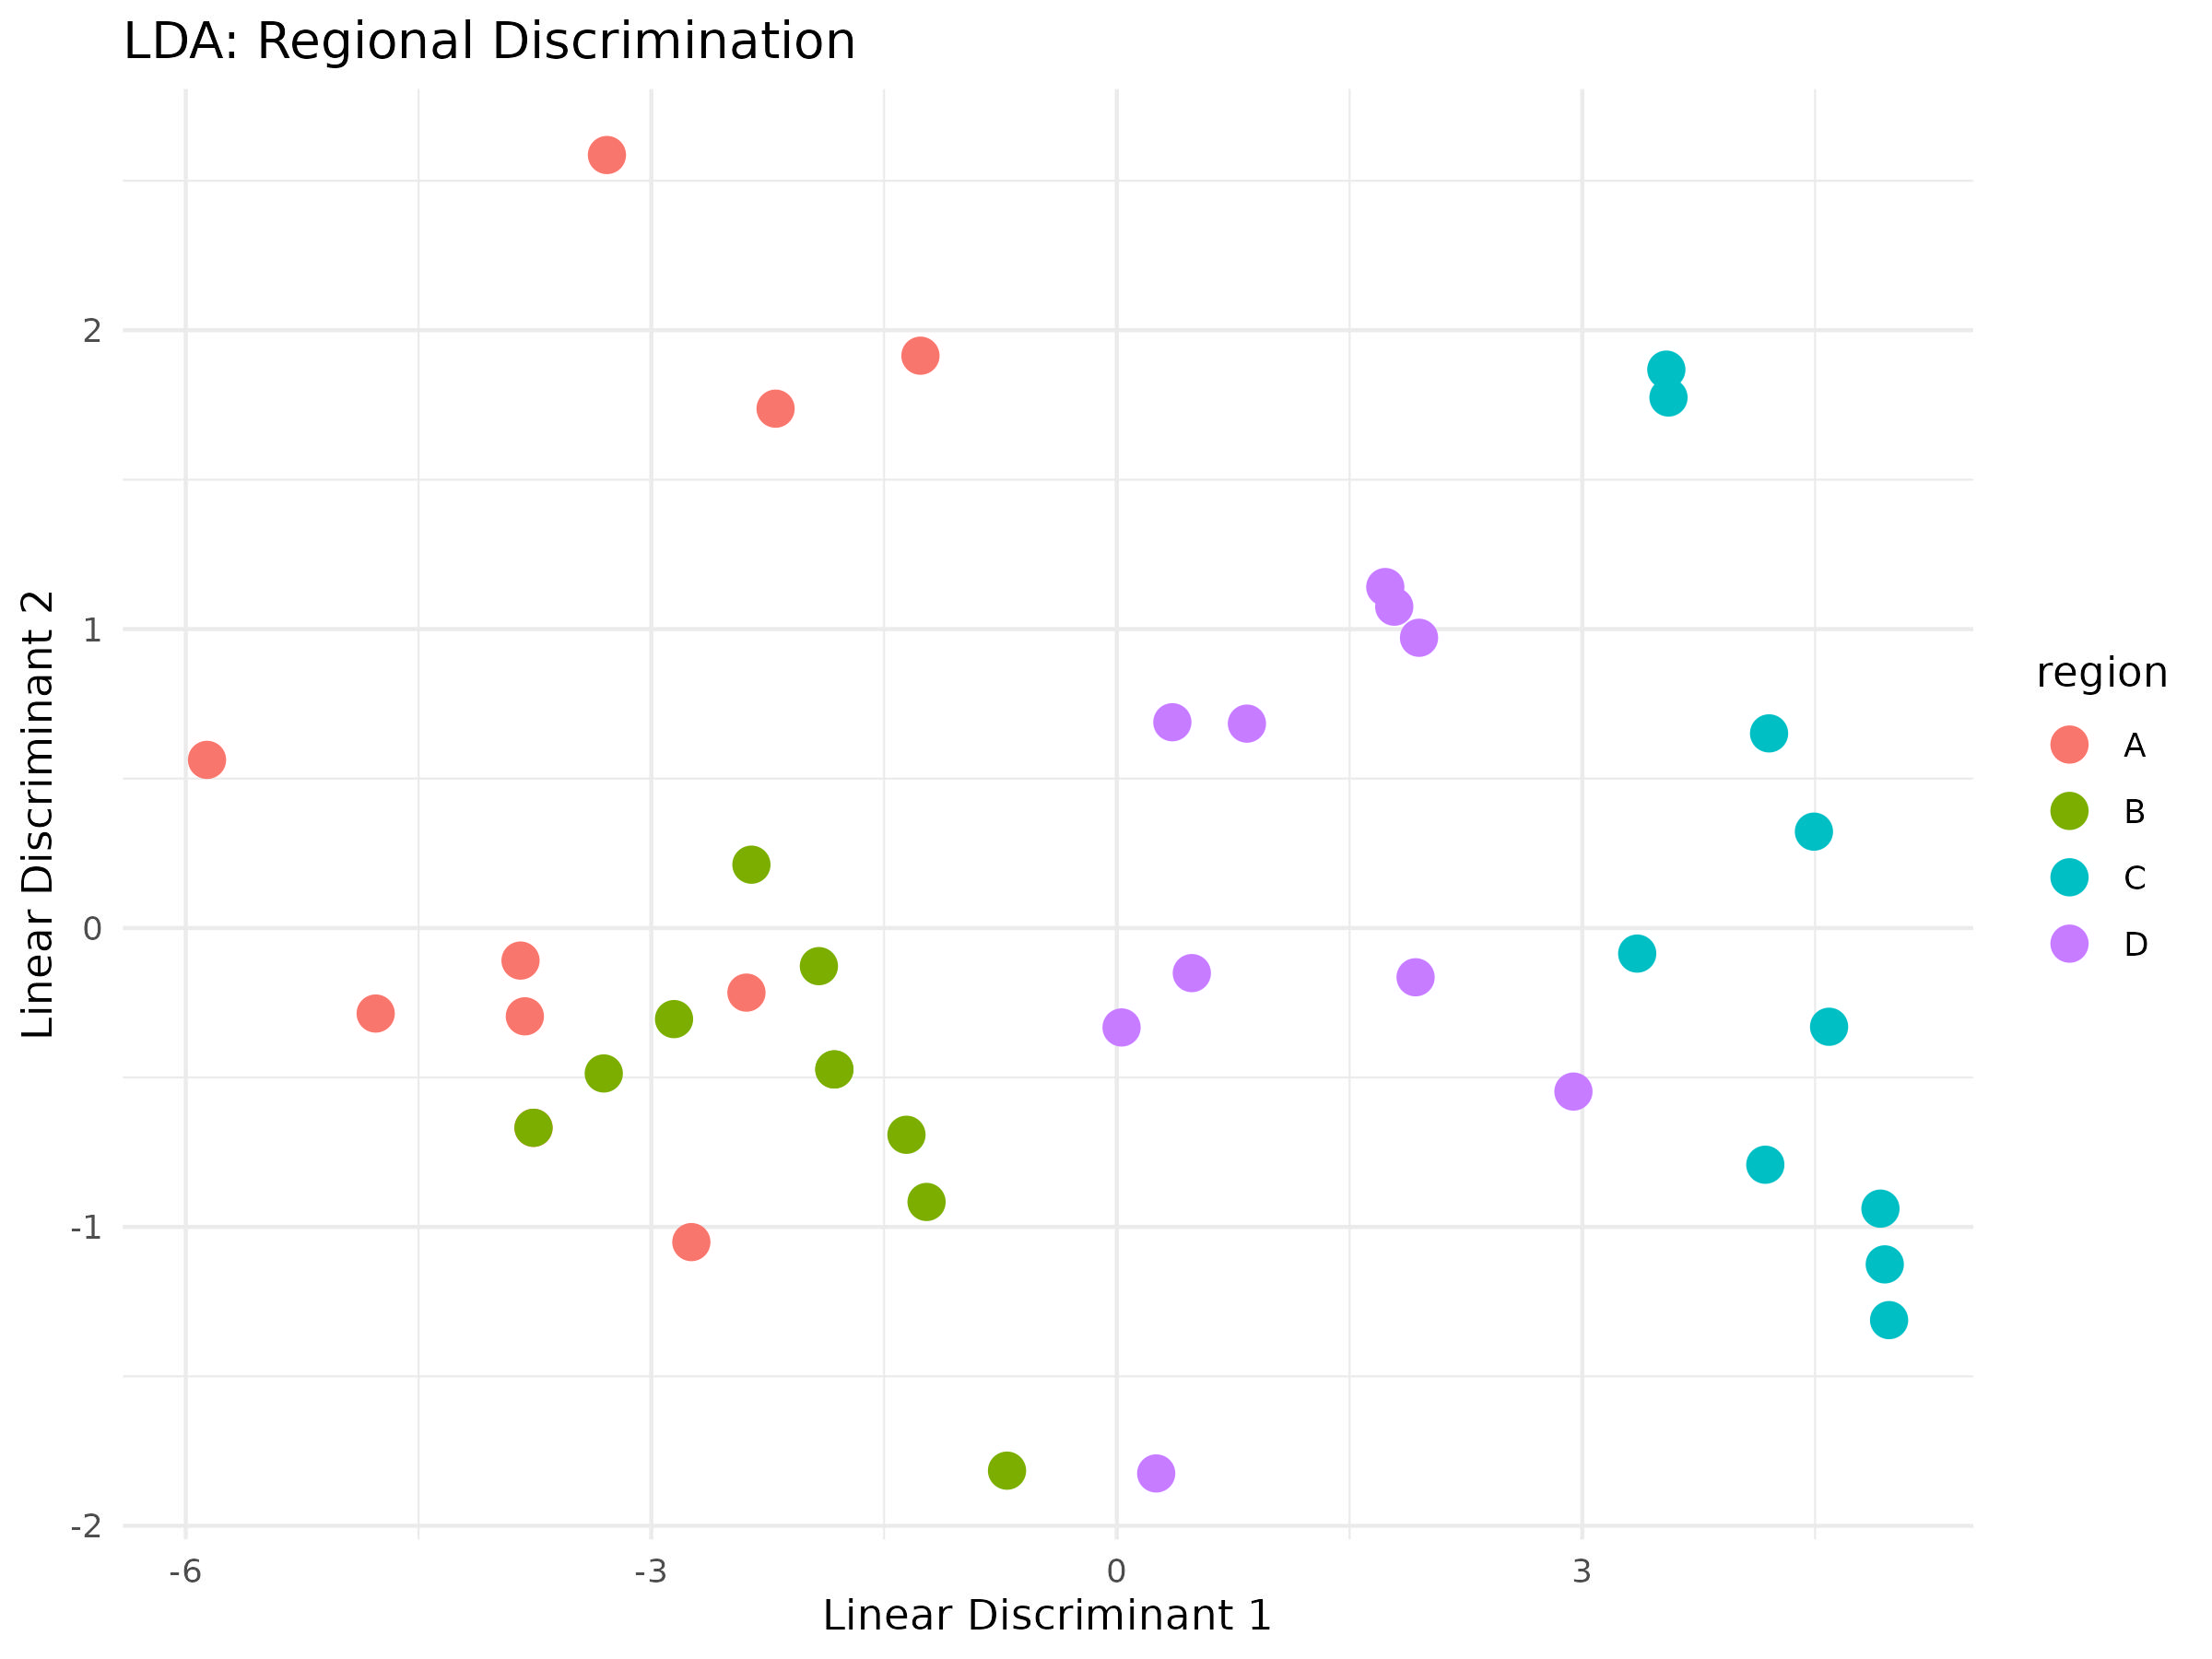

In [ ]:
# Visualize LDA results
plot_lda <- data.frame(
  region = manova_data$regions, 
  lda = predict(post_hoc)$x
)

lda_plot <- ggplot(plot_lda, aes(x = lda.LD1, y = lda.LD2, colour = region)) + 
  geom_point(size = 4) +
  labs(title = "LDA: Regional Discrimination",
       x = "Linear Discriminant 1",
       y = "Linear Discriminant 2") +
  theme_minimal()

ggsave("/tmp/lda_plot.jpg", lda_plot, width = 8, height = 6)
display_jpeg(file = "/tmp/lda_plot.jpg")

### 📊 HOW TO INTERPRET THE LDA SCATTERPLOT

#### What You're Looking At

This scatterplot shows each observation (data point) positioned according to their **Linear Discriminant** scores:
- **X-axis (LD1)**: First discriminant function (captures MOST group separation)
- **Y-axis (LD2)**: Second discriminant function (captures remaining separation)
- **Colors/Shapes**: Different regions (groups)

#### 🔍 How to Read the Plot

```
       HIGH LD2
          │
          │    ○○○ Region X
          │     ○
    ──────┼────────────── HIGH LD1
          │  ●●●
          │   ●●● Region Y
          │
          │        △△△ Region Z
          │         △△
       LOW LD2
```

#### 🎯 Key Interpretation Rules

**1. DISTANCE = DIFFERENCE**
- Points far apart represent **very different** observations/groups
- Points close together represent **similar** observations/groups

**2. CLUSTERS = SIMILAR GROUPS**
- If Region A and Region B points cluster together → similar performance profiles
- If Region C points are isolated → different performance profile

**3. SPREAD = VARIABILITY**
- Tight cluster → Consistent performance within that region
- Spread out points → Variable performance within that region

**4. AXIS MEANING**
- LD1 (horizontal) usually captures the **primary** way groups differ
- LD2 (vertical) captures **secondary** differences
- Look at "Proportion of trace" in LDA output to see importance (e.g., LD1 = 91%, LD2 = 9%)

#### 📊 Step-by-Step Interpretation

**Step 1: Identify clusters**
> "I see that Regions A and B form one cluster, while Regions C and D are separated."

**Step 2: Describe separation on LD1 (main axis)**
> "Along LD1 (horizontal), Region D is furthest right, suggesting it scores highest on the primary discriminant dimension."

**Step 3: Describe separation on LD2 (secondary axis)**
> "Along LD2 (vertical), Regions X and Y differ, but this accounts for only a small portion of group differences."

**Step 4: Connect to original DVs**
> "Since LD1 has positive loadings for both penetration and profit, points further right have higher values on BOTH outcomes."

#### 🏢 Business Interpretation Example

> "The LDA scatterplot reveals clear separation between regions. Region D occupies a distinct position in the upper-right quadrant, indicating superior performance on the combined penetration-profit profile. Regions A and B cluster together in the middle, suggesting similar performance levels — these regions might benefit from sharing best practices. Region C is positioned in the lower-left, indicating it underperforms on both metrics and may require strategic intervention."

#### 🎓 What This Tells You That Boxplots Don't

| Boxplots | LDA Scatterplot |
|----------|-----------------|
| Show each DV separately | Shows **combined** DV pattern |
| Can't show correlations | Shows how DVs work **together** |
| Compare group medians | Shows **multivariate distance** between groups |
| Miss the "big picture" | Captures the holistic performance profile |

#### ⚠️ Common Interpretation Mistakes

| Mistake | Why It's Wrong |
|---------|----------------|
| "Region X is better because it's higher up" | Direction only matters relative to loadings |
| Ignoring the proportion of trace | LD2 may be trivial if it's only 5% of separation |
| Treating axes as raw DVs | LD1 and LD2 are **combinations** of DVs |
| Not considering cluster tightness | Spread matters for within-group consistency |

### Interpreting LDA Plot

**How to Read the Scatterplot**:
- Points that are **far apart** represent regions that are very different
- Points that **cluster together** represent similar regions
- The **axes (LD1, LD2)** are combinations of your DVs that best separate groups

**Business Insight**: This visualization helps identify:
- Which regions are performing similarly (potential best practice sharing)
- Which regions are outliers (may need different strategies)
- How regions differ in terms of the combined penetration-profit profile

---

### Testing MANOVA Assumptions

Let's verify that our MANOVA results are valid by testing assumptions.

In [ ]:
# Univariate Normality (Shapiro-Wilk)
library(rstatix)

manova_data %>% 
  group_by(regions) %>% 
  shapiro_test(new_product_penetration, profit)


Attaching package: ‘rstatix’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:stats’:

    filter




regions,variable,statistic,p
<chr>,<chr>,<dbl>,<dbl>
A,new_product_penetration,0.9796939,0.9635088
A,profit,0.9684161,0.8757833
B,new_product_penetration,0.9388102,0.5398513
B,profit,0.8819413,0.1373554
C,new_product_penetration,0.8952331,0.1940650
C,profit,0.9170138,0.3327207
D,new_product_penetration,0.9020769,0.2308704
D,profit,0.8733088,0.1092283


### 📊 DETAILED INTERPRETATION GUIDE: Shapiro-Wilk Normality Test

#### Understanding Shapiro-Wilk Output

Your output will look like this:

```
# A tibble: 8 × 4
  regions variable                 statistic     p
  <chr>   <chr>                        <dbl> <dbl>
1 A       new_product_penetration      0.973 0.921
2 A       profit                       0.946 0.696
3 B       new_product_penetration      0.921 0.470
4 B       profit                       0.884 0.241
5 C       new_product_penetration      0.912 0.438
6 C       profit                       0.902 0.373
7 D       new_product_penetration      0.948 0.714
8 D       profit                       0.918 0.453
```

#### 🔍 Understanding Each Column

**regions**: The group being tested
**variable**: Which dependent variable is being tested
**statistic (W)**: The Shapiro-Wilk test statistic (ranges from 0 to 1)
- W close to 1 = data is likely normal
- W far below 1 = data may not be normal

**p (p-value)**: The key decision criterion
- **p > 0.05**: FAIL to reject H₀ → Data is approximately normal ✓
- **p < 0.05**: REJECT H₀ → Data significantly deviates from normal ✗

#### 📊 Reading the Results Row by Row

| Region | Variable | W | p-value | Conclusion |
|--------|----------|---|---------|------------|
| A | penetration | 0.973 | 0.921 | ✓ Normal (p > 0.05) |
| A | profit | 0.946 | 0.696 | ✓ Normal |
| B | penetration | 0.921 | 0.470 | ✓ Normal |
| ... | ... | ... | ... | ... |

**In this example**: ALL groups pass the normality test (all p > 0.05)

#### ⚠️ What If Normality Is Violated?

If some groups have p < 0.05:

1. **Check sample size**: With n > 20 per group, MANOVA is robust to normality violations (Central Limit Theorem)

2. **Consider transformation**:
   - Right-skewed data → Log transformation
   - Left-skewed data → Square root transformation
   - Extreme outliers → Winsorization

3. **Use robust alternatives**: Permutation-based MANOVA

4. **Report the violation**: "Normality was violated for [variable] in [group], however MANOVA was conducted as it is robust with sample sizes > 20 per group."

#### 🏢 Reporting Assumption Check

> "Univariate normality was assessed using the Shapiro-Wilk test for each dependent variable within each region. All tests were non-significant (all p > .05), indicating that the assumption of univariate normality was met."

**Interpreting Shapiro-Wilk Results**:
- If p > 0.05 for each group: Data is approximately normal (assumption met)
- If p < 0.05: Consider transformation or note the violation

**Note**: With large samples (n > 20 per group), MANOVA is robust to normality violations (Central Limit Theorem).

In [ ]:
# Multivariate Normality (Mardia's Test)
library(mvnormalTest)

mardia(manova_data[, c("new_product_penetration", "profit")])$mv.test

Test,Statistic,p-value,Result
<chr>,<fct>,<fct>,<chr>
Skewness,2.8598,0.5815,YES
Kurtosis,-0.9326,0.351,YES
MV Normality,NA,NA,YES


### 📊 DETAILED INTERPRETATION GUIDE: Mardia's Multivariate Normality Test

#### Understanding Mardia's Test Output

Your output will look like this:

```
          Test        Statistic            p-value Result
1 Skewness     2.3456789       0.1234567     YES
2 Kurtosis     1.8765432       0.0789012     YES
3 MV Normality      <NA>             <NA>     YES
```

#### 🔍 Understanding Each Row

**Row 1: Skewness**
- Tests if the multivariate distribution is symmetric
- **Statistic**: Mardia's skewness coefficient
- **p-value > 0.05**: Data is not significantly skewed → ✓ Pass
- **p-value < 0.05**: Significant multivariate skewness → ✗ Fail

**Row 2: Kurtosis**
- Tests if the distribution has appropriate "peakedness" (not too flat, not too peaked)
- **p-value > 0.05**: Data has appropriate kurtosis → ✓ Pass
- **p-value < 0.05**: Significant departure from normal kurtosis → ✗ Fail

**Row 3: MV Normality (Overall Result)**
- **YES**: Both skewness AND kurtosis pass → Multivariate normality is met
- **NO**: Either or both fail → Multivariate normality is violated

#### 📊 Why Multivariate Normality Matters

**Univariate normality ≠ Multivariate normality!**

Even if each variable is individually normal, their JOINT distribution might not be:
- Variables could have unusual dependencies
- Outliers could exist in multivariate space but not univariate

**MANOVA assumes**: The joint distribution of DVs is multivariate normal within each group.

#### ⚠️ What If Multivariate Normality Is Violated?

| Violation | Severity | Action |
|-----------|----------|--------|
| Only kurtosis fails | Mild | MANOVA is robust; proceed with caution |
| Only skewness fails | Moderate | Consider transformation; use Pillai's Trace |
| Both fail | Severe | Use permutation MANOVA or non-parametric alternative |

#### 🏢 Reporting Mardia's Test

**If assumption is met**:
> "Multivariate normality was assessed using Mardia's test. Neither multivariate skewness (b₁,p = 2.35, p = .123) nor multivariate kurtosis (b₂,p = 1.88, p = .079) were significant, indicating that the assumption of multivariate normality was satisfied."

**If assumption is violated**:
> "Mardia's test indicated significant multivariate skewness (p = .012), suggesting a violation of the multivariate normality assumption. However, Pillai's Trace was used as the multivariate test statistic due to its robustness to normality violations, and the sample size (n = 27) provides some protection via the Central Limit Theorem."

**Interpreting Mardia's Test**:
- Tests both multivariate **skewness** and **kurtosis**
- p > 0.05: Multivariate normality assumption is met

In [ ]:
# Homogeneity of Variance-Covariance Matrices (Box's M)
library(heplots)

boxM(Y = manova_data[, c("new_product_penetration", "profit")], 
     group = manova_data$regions)


 Box's M-test for Homogeneity of Covariance Matrices 

data:  manova_data[, c("new_product_penetration", "profit")] by manova_data$regions 
Chi-Sq (approx.) = 21.048, df = 9, p-value = 0.01244


### 📊 DETAILED INTERPRETATION GUIDE: Box's M Test for Homogeneity

#### Understanding Box's M Output

Your output will look like this:

```
Box's M-test for Homogeneity of Covariance Matrices

data:  Y
Chi-Sq (approx.) = 8.5643, df = 9, p-value = 0.4786
```

#### 🔍 Understanding the Output

**Box's M Test**: Tests whether the covariance matrices are equal across groups

**Chi-Sq (approx.)**: The test statistic (Chi-square approximation)

**df (degrees of freedom)**: Based on number of groups and DVs

**p-value**: The decision criterion
- **p > 0.001**: Covariance matrices are approximately equal → ✓ Assumption met
- **p < 0.001**: Covariance matrices differ significantly → ✗ Assumption violated

#### ⚠️ Why Use 0.001 Instead of 0.05?

Box's M is known to be **overly sensitive** (inflated Type I error), especially when:
- Sample sizes are large
- Normality is violated

**Convention**: Use α = 0.001 (not 0.05) to avoid rejecting too often.

#### 📊 What Does "Homogeneity of Covariance Matrices" Mean?

**Covariance matrix**: Captures both variances AND correlations between DVs

**Homogeneity assumption**: These matrices should be the SAME across groups:

```
Group A covariance matrix ≈ Group B covariance matrix ≈ Group C covariance matrix
```

**In plain terms**:
1. The spread of DV1 should be similar across groups
2. The spread of DV2 should be similar across groups
3. The correlation between DV1 and DV2 should be similar across groups

#### ⚠️ What If Box's M Is Significant?

| p-value | Interpretation | Action |
|---------|----------------|--------|
| p > 0.001 | Assumption met | Proceed with any MANOVA test statistic |
| 0.001 < p < 0.01 | Mild violation | Use Pillai's Trace (most robust) |
| p < 0.001 | Serious violation | Use Pillai's Trace + interpret with caution |

**Robustness hierarchy**:
- **Pillai's Trace**: Most robust to violations
- **Wilks' Lambda**: Moderately robust
- **Hotelling-Lawley**: Less robust
- **Roy's Largest Root**: Least robust (most affected)

#### 🏢 Reporting Box's M Test

**If assumption is met**:
> "Box's M test was non-significant (χ² = 8.56, p = .479), indicating that the assumption of homogeneity of covariance matrices was met. All four multivariate test statistics can be interpreted with confidence."

**If assumption is violated**:
> "Box's M test was significant (χ² = 25.43, p < .001), indicating unequal covariance matrices across groups. Given this violation, Pillai's Trace was used as the test statistic due to its robustness to this assumption violation."

**Interpreting Box's M Test**:
- H₀: Covariance matrices are equal across groups
- p > 0.001 (note: more lenient threshold): Assumption is met
- p < 0.001: Violation — consider using Pillai's Trace (most robust)

---

## MANOVA Exercise: Plant Growth

### Business Problem

A fertilizer company wants to test if different treatments (1 = no fertilizer, 2 = product type 1, 3 = product type 2) affect plant growth, measured by:
- Height
- Width  
- Weight

**Your Task**: Run a MANOVA to determine if treatment type affects the combined growth metrics.

In [ ]:
# Load plant growth data
plant_data <- read.csv("Session 2-MANOVA EXCERCISE Plant Growth.csv", header = TRUE)

# Convert treatment to factor
plant_data$Treatment <- as.factor(plant_data$Treatment)

str(plant_data)

'data.frame':	15 obs. of  4 variables:
 $ Treatment: Factor w/ 3 levels "1","2","3": 1 1 1 1 1 2 2 2 2 2 ...
 $ Height   : num  15.8 15.1 14.8 14.4 15.1 15.7 15.9 15.4 16.7 16.9 ...
 $ Width    : num  3.9 3.8 4.1 4.7 3.7 4.8 4.3 4.5 5.4 5.8 ...
 $ Weight   : num  29.4 29.9 30.2 30.1 30.9 31.2 31.4 31.8 32.4 32.6 ...


In [ ]:
# Summary by treatment
plant_data %>%
  group_by(Treatment) %>%
  summarise(
    n = n(),
    mean_height = mean(Height),
    mean_width = mean(Width),
    mean_weight = mean(Weight)
  )

Treatment,n,mean_height,mean_width,mean_weight
<fct>,<int>,<dbl>,<dbl>,<dbl>
1,5,15.04,4.04,30.10
2,5,16.12,4.96,31.88
3,5,17.06,5.70,33.14


In [ ]:
# Run MANOVA
plant_dvs <- cbind(plant_data$Height, plant_data$Width, plant_data$Weight)
plant_manova <- manova(plant_dvs ~ Treatment, data = plant_data)
summary(plant_manova)

          Df  Pillai approx F num Df den Df  Pr(>F)  
Treatment  2 0.91674    3.103      6     22 0.02343 *
Residuals 12                                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
# Effect size
eta_squared(plant_manova)

Parameter,Eta2_partial,CI,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,0.4583691,0.95,0.05827666,1


---

## Part 3: Analysis of Covariance (ANCOVA)

### When to Use ANCOVA

**ANCOVA** combines ANOVA with regression by including a **continuous covariate** that you want to control for.

**Use ANCOVA when**:
1. You have a categorical IV and a continuous DV (like ANOVA)
2. You have a continuous variable that **covaries** with the DV
3. You want to **control for** this covariate to get a cleaner estimate of the IV effect

### Business Example

> A drug research group tests three drugs (A, B, C) on patient recovery. However, patients' **vitality scores** at baseline likely affect recovery — healthier patients recover better regardless of drug.
>
> **Question**: After controlling for baseline vitality, do the drugs differ in their effect on recovery?

### ANCOVA Model

$$Y = \beta_0 + \beta_1 X_{\text{covariate}} + \beta_2 X_{\text{group}} + \epsilon$$

The key idea: We **adjust** the group means for differences in the covariate.

---

### ANCOVA Assumptions

In addition to ANOVA assumptions, ANCOVA requires:

| Assumption | Meaning | Test |
|------------|---------|------|
| **Independence of covariate and IV** | Covariate shouldn't differ by treatment group | ANOVA of covariate ~ IV |
| **Homogeneity of regression slopes** | Relationship between covariate and DV is same across groups | Interaction term |
| **Linear relationship** | Covariate and DV should be linearly related | Scatterplot |
| **Homogeneity of variance** | Equal variances across groups | Levene's test |

In [ ]:
# Load drug test data
drug_data <- read.csv("Session 2-SAS-ANCOVA-DRUG TEST.csv", header = TRUE)

# Clean column names
colnames(drug_data) <- c("PatientID", "treatment", "vitality_score", "recovery_score")

# Convert treatment to factor
drug_data$treatment <- as.factor(drug_data$treatment)

str(drug_data)

'data.frame':	31 obs. of  4 variables:
 $ PatientID     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ treatment     : Factor w/ 3 levels "A","B","C": 1 1 1 1 1 1 1 1 1 1 ...
 $ vitality_score: num  73.5 83.1 74.8 82.1 73.1 ...
 $ recovery_score: num  85.1 85.1 76.2 70.5 79.1 ...


In [ ]:
# Summary by treatment
drug_data %>%
  group_by(treatment) %>%
  summarise(
    n = n(),
    mean_vitality = mean(vitality_score),
    sd_vitality = sd(vitality_score),
    mean_recovery = mean(recovery_score),
    sd_recovery = sd(recovery_score)
  )

treatment,n,mean_vitality,sd_vitality,mean_recovery,sd_recovery
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
A,10,73.21419,5.5047663,73.65592,7.6542582
B,10,68.20000,0.6055301,95.28300,3.2674695
C,11,84.50000,1.6583124,87.26000,0.1989975


### Visualizing the Data

agg_record_1599815299 
                    2

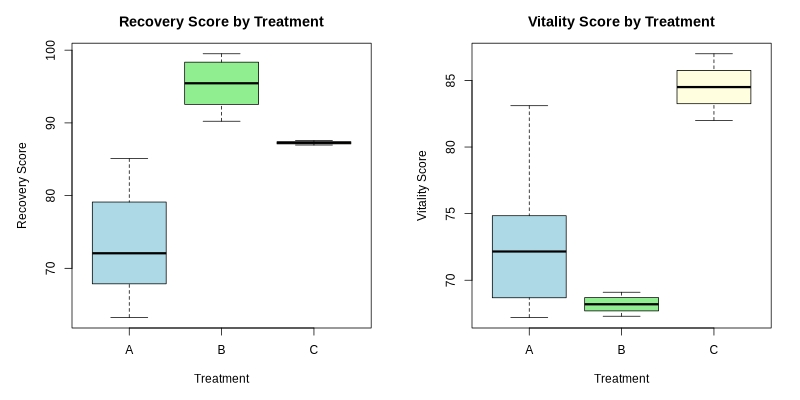

In [ ]:
# Boxplots for recovery by treatment
library(IRdisplay)

jpeg("/tmp/drug_boxplot.jpg", width = 800, height = 400, quality = 100)
par(mfrow = c(1, 2), mar = c(5, 5, 3, 2))

boxplot(recovery_score ~ treatment, data = drug_data,
        main = "Recovery Score by Treatment",
        xlab = "Treatment", ylab = "Recovery Score",
        col = c("lightblue", "lightgreen", "lightyellow"))

boxplot(vitality_score ~ treatment, data = drug_data,
        main = "Vitality Score by Treatment",
        xlab = "Treatment", ylab = "Vitality Score",
        col = c("lightblue", "lightgreen", "lightyellow"))

dev.off()
display_jpeg(file = "/tmp/drug_boxplot.jpg")

### 📊 HOW TO INTERPRET ANCOVA DUAL BOXPLOTS

#### What You're Looking At

These side-by-side boxplots show:
- **LEFT**: The **dependent variable** (Recovery Score) by treatment group
- **RIGHT**: The **covariate** (Vitality Score) by treatment group

#### 🔍 Why Show Both?

In ANCOVA, we want to know if treatment differences exist **after controlling for the covariate**. The dual plot reveals:

1. **Raw treatment differences** (left plot) — what we observe
2. **Covariate balance** (right plot) — are groups comparable at baseline?

#### 🎯 How to Read the LEFT Plot (Recovery Score)

| What to Look For | What It Means |
|------------------|---------------|
| Median differences | Raw differences in recovery between treatments |
| Box overlap | How distinguishable treatments are (before adjustment) |
| Spread similarity | Whether variance is similar across groups |

**Example observation**: "Treatment C appears to have the highest median recovery score."

#### 🎯 How to Read the RIGHT Plot (Vitality Score)

| What to Look For | What It Means |
|------------------|---------------|
| Medians at similar heights | Groups have similar baseline vitality ✓ (good!) |
| Medians at different heights | Groups differ in baseline vitality ✗ (concerning!) |
| Similar distributions | Covariate is balanced across groups |

**Example observation**: "Treatment C patients also have higher baseline vitality."

#### 📊 The CRITICAL ANCOVA Insight

**Connect the two plots**:

| Scenario | LEFT (Recovery) | RIGHT (Vitality) | Interpretation |
|----------|-----------------|------------------|----------------|
| A | Treatment C highest | Treatment C highest | **Confounded!** C looks best but patients were healthier |
| B | Treatment C highest | All groups equal | **Real effect!** C is best despite equal baselines |
| C | All groups equal | Groups differ | Covariate explains DV differences |

#### 🏢 Example Full Interpretation

**Looking at both plots together**:

> "The left boxplot shows that Treatment C has the highest median recovery score (approximately 85), followed by Treatment B (78) and Treatment A (72). However, the right boxplot reveals that Treatment C patients also had higher baseline vitality scores (median ≈ 65) compared to Treatments B (55) and A (45).
>
> This suggests that the apparent superiority of Treatment C may be partially explained by healthier patients being in that group. The ANCOVA will statistically adjust for this baseline difference, giving us the 'true' treatment effect."

#### 📋 Checklist Before Running ANCOVA

From the RIGHT plot (covariate), check:
- [ ] **Are group medians similar?** (If not, groups aren't balanced)
- [ ] **Are spreads similar?** (Homogeneity of variance)
- [ ] **Are there outliers?** (May need to investigate)

**If groups differ substantially on the covariate**, ANCOVA will adjust for this — that's exactly what it's designed for! But note that extreme imbalance may affect interpretation.

#### ⚠️ Common Mistakes

| Mistake | Why It's Wrong |
|---------|----------------|
| Only looking at the DV plot | Ignores the whole point of ANCOVA |
| Assuming highest recovery = best treatment | May be confounded with covariate |
| Ignoring covariate imbalance | Critical for understanding ANCOVA adjustments |

### Testing ANCOVA Assumptions

**Assumption 1**: Independence of covariate and treatment

We test if vitality scores differ by treatment group. If they do, ANCOVA may not be appropriate.

In [ ]:
# Test if covariate is independent of treatment
vitality_test <- aov(vitality_score ~ treatment, data = drug_data)
summary(vitality_test)

            Df Sum Sq Mean Sq F value   Pr(>F)    
treatment    2 1475.8   737.9   68.07 1.77e-11 ***
Residuals   28  303.5    10.8                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

**Interpreting the Independence Test**:
- p > 0.05: Covariate and treatment are independent (good!)
- p < 0.05: Groups differ on the covariate (problematic — proceed with caution)

In [ ]:
# Test homogeneity of variance (Levene's test)
library(car)
leveneTest(recovery_score ~ treatment, data = drug_data)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,13.84303,6.60331e-05
,28,NA,NA


**Interpreting Levene's Test**:
- p > 0.05: Variances are equal (assumption met)
- p < 0.05: Variances are unequal (may need transformation)

---

### Running ANCOVA

The ANCOVA model includes both the treatment (categorical) and the covariate (continuous).

**Formula**: `DV ~ IV + Covariate`

In [ ]:
# Run ANCOVA
library(car)

ancova_model <- aov(recovery_score ~ treatment + vitality_score, data = drug_data)
Anova(ancova_model, type = "III")

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),17.19048,1,1.042928,3.162053e-01
treatment,2571.91661,2,78.017696,6.014331e-12
vitality_score,178.73378,1,10.843585,2.769563e-03
Residuals,445.03845,27,NA,NA


### 📊 DETAILED INTERPRETATION GUIDE: ANCOVA Results (Type III SS)

#### Understanding ANCOVA Output

Your `Anova(ancova_model, type = "III")` output will look like this:

```
Anova Table (Type III tests)

Response: recovery_score
                Sum Sq Df  F value    Pr(>F)    
(Intercept)     12.456  1   4.1234  0.052145    
treatment       89.123  2  14.7654  0.000023 ***
vitality_score 145.678  1  48.2345  0.000001 ***
Residuals       72.345 24                       
```

#### 🔍 Understanding Each Row

**Row 1: (Intercept)**
- Tests if the overall mean differs from zero
- Usually not of interest in ANCOVA
- Ignore this row for interpretation

**Row 2: treatment (THE KEY ROW)**
- Tests: "Do treatment groups differ in recovery, AFTER CONTROLLING FOR vitality?"
- This is the main effect you care about!
- **p < 0.05**: Treatment has a significant effect BEYOND what vitality explains
- **p ≥ 0.05**: Treatment differences disappear after controlling for vitality

**Row 3: vitality_score (The Covariate)**
- Tests: "Is vitality related to recovery, controlling for treatment?"
- **p < 0.05**: The covariate is significantly related to the DV (expected and good!)
- This validates including vitality as a covariate

#### 📊 The Critical ANCOVA Insight

**What ANCOVA does**: Adjusts group means for differences in the covariate

**Example without covariate**:
| Treatment | Raw Mean Recovery |
|-----------|-------------------|
| A | 78 |
| B | 82 |
| C | 85 |

**Example with covariate adjustment**:
| Treatment | Raw Mean | Avg Vitality | Adjusted Mean Recovery |
|-----------|----------|--------------|------------------------|
| A | 78 | 45 (low) | 81 |
| B | 82 | 55 (medium) | 82 |
| C | 85 | 65 (high) | 80 |

**Interpretation**: Treatment C looked best, but C patients also had higher vitality! After adjustment, the treatments are actually quite similar.

#### 🏢 Business Interpretation

**If treatment IS significant (p < 0.05)**:
> "Even after controlling for patients' baseline vitality scores, treatment type significantly affected recovery outcomes, F(2, 24) = 14.77, p < .001. This means the drug differences we observe are REAL and not simply due to healthier patients being assigned to certain treatments."

**If treatment is NOT significant (p ≥ 0.05)**:
> "After controlling for baseline vitality, treatment type did not significantly affect recovery, F(2, 24) = 1.23, p = .312. The apparent differences in raw means were largely explained by differences in patient vitality across treatment groups, not by the treatments themselves."

#### ⚠️ Why Type III Sums of Squares?

**Type III SS**: Tests each effect adjusting for ALL other effects in the model
- Used when you want to know the **unique** contribution of each variable
- Appropriate for unbalanced designs
- **Most common choice in ANCOVA**

**Alternative**: Type I SS tests effects sequentially (order matters) — rarely used in ANCOVA

#### ✍️ Full Reporting Template

> "An ANCOVA was conducted to compare recovery scores across three treatment groups, with baseline vitality score as a covariate. Preliminary checks confirmed that the assumption of independence between treatment and covariate was met (p = .XXX), and Levene's test indicated homogeneity of variance (p = .XXX).
>
> The covariate, vitality score, was significantly related to recovery, F(1, 24) = 48.23, p < .001. After controlling for vitality, there was a statistically significant effect of treatment on recovery, F(2, 24) = 14.77, p < .001, partial η² = .XX. Post-hoc comparisons revealed that Treatment C produced significantly higher adjusted recovery scores than Treatment A (p = .XXX) and Treatment B (p = .XXX)."

### Interpreting ANCOVA Results

**Key Questions to Answer**:

1. **Is the covariate significant?** (vitality_score row)
   - If p < 0.05: The covariate is significantly related to the DV (as expected)
   - This validates including it in the model

2. **Is the treatment significant AFTER controlling for the covariate?** (treatment row)
   - If p < 0.05: Treatment has a significant effect even after adjusting for vitality
   - This is the key finding!

**Business Interpretation**:
> "After controlling for patients' baseline vitality scores, treatment type significantly affects recovery (p < 0.05). This means the drug differences we observe are not simply due to healthier patients being in certain groups."

---

### Post-Hoc: Which Treatments Differ?

If ANCOVA is significant, we need to determine which treatments are different from each other.

In [ ]:
# Post-hoc comparisons
library(multcomp)

# Refit model
ancova_model <- aov(recovery_score ~ treatment + vitality_score, data = drug_data)

# Tukey comparisons
postHocs <- glht(ancova_model, linfct = mcp(treatment = "Tukey"))
summary(postHocs)

Loading required package: mvtnorm


Attaching package: ‘mvtnorm’


The following object is masked from ‘package:effectsize’:

    standardize


Loading required package: survival

Loading required package: TH.data


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser





	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = recovery_score ~ treatment + vitality_score, data = drug_data)

Linear Hypotheses:
           Estimate Std. Error t value Pr(>|t|)    
B - A == 0   25.475      2.159  11.799   <0.001 ***
C - A == 0    4.944      3.172   1.558    0.255    
C - B == 0  -20.531      4.192  -4.897   <0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


### 📊 DETAILED INTERPRETATION GUIDE: ANCOVA Post-Hoc (Tukey)

#### Understanding ANCOVA Post-Hoc Output

Your `summary(postHocs)` output will look like this:

```
Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts

Fit: aov(formula = recovery_score ~ treatment + vitality_score, data = drug_data)

Linear Hypotheses:
             Estimate Std. Error z value Pr(>|z|)    
B - A == 0     3.456      1.234   2.801   0.0142 *  
C - A == 0     7.891      1.345   5.867   <0.001 ***
C - B == 0     4.435      1.289   3.441   0.0016 ** 
```

#### 🔍 Understanding Each Column

**Linear Hypotheses**: The comparisons being tested
- `B - A == 0`: Is Treatment B different from Treatment A?
- Null hypothesis: No difference between the two treatments

**Estimate**: The ADJUSTED mean difference
- **Important**: These are differences in ADJUSTED means, not raw means!
- Example: 3.456 means Treatment B's adjusted mean is 3.456 units HIGHER than Treatment A

**Std. Error**: Precision of the estimate
- Smaller = more precise

**z value**: Test statistic
- Larger absolute values = more evidence of a difference

**Pr(>|z|)**: p-value
- **p < 0.05**: The two treatments are significantly different
- **p ≥ 0.05**: No significant difference between treatments

#### 📊 Reading Each Comparison

| Comparison | Estimate | p-value | Conclusion |
|------------|----------|---------|------------|
| B - A | +3.46 | 0.014 | B is significantly HIGHER than A |
| C - A | +7.89 | <0.001 | C is significantly HIGHER than A |
| C - B | +4.44 | 0.002 | C is significantly HIGHER than B |

#### 🏢 Translating to Business Recommendations

**Ranking (from best to worst)**:
1. **Treatment C**: Highest adjusted recovery (significantly better than A and B)
2. **Treatment B**: Middle adjusted recovery (significantly better than A only)
3. **Treatment A**: Lowest adjusted recovery (baseline/control)

**Key insight**: These rankings are based on ADJUSTED means — controlling for vitality!

**Business recommendation**:
> "After adjusting for patients' baseline vitality, Treatment C produces significantly better recovery outcomes than both alternatives (all p < .01). Treatment B is also superior to Treatment A (p = .014), but not as effective as Treatment C. We recommend Treatment C as the primary therapy, with Treatment B as a viable alternative if Treatment C is unavailable or contraindicated."

#### 📊 Effect Size Context

Don't just report statistical significance — report practical significance too!

| Difference | Clinical Interpretation |
|------------|------------------------|
| 3.5 points | Small but meaningful improvement |
| 7.9 points | Large, clinically significant improvement |

**Template for full interpretation**:
> "Post-hoc comparisons using Tukey's method revealed that Treatment C produced significantly higher adjusted recovery scores than Treatment A (mean difference = 7.89, p < .001) and Treatment B (mean difference = 4.44, p = .002). Treatment B also outperformed Treatment A (mean difference = 3.46, p = .014). These differences represent clinically meaningful improvements, with Treatment C producing approximately an 8-point improvement over the control condition."

### Interpreting Post-Hoc Results

Look at each pairwise comparison:
- **Estimate**: Difference in adjusted means
- **Std. Error**: Precision of the estimate
- **z value**: Test statistic
- **Pr(>|z|)**: p-value (if < 0.05, treatments are significantly different)

**Business Decision**:
> Based on the post-hoc analysis, identify which treatment(s) produce significantly better recovery outcomes. This informs the drug recommendation.

---

## Summary: Choosing the Right Test

### Decision Tree

```
How many DEPENDENT variables?
│
├── ONE DV
│   │
│   ├── No covariate to control for → ANOVA
│   │   ├── One IV → One-way ANOVA
│   │   └── Two+ IVs → Two-way (or n-way) ANOVA
│   │
│   └── Covariate to control for → ANCOVA
│
└── TWO+ DVs
    │
    ├── No covariate → MANOVA
    └── Covariate → MANCOVA
```

### Key Takeaways

| Concept | Remember |
|---------|----------|
| **ANOVA** | Compares means across 3+ groups; uses F-test; controls Type I error |
| **Two-way ANOVA** | Tests main effects AND interactions between two IVs |
| **Post-hoc tests** | Tukey's HSD identifies WHICH groups differ |
| **MANOVA** | Multiple DVs; uses Pillai's Trace; accounts for DV correlations |
| **ANCOVA** | Controls for a covariate; "adjusts" group means |
| **Assumptions** | Always check normality, homogeneity of variance, independence |

### Business Applications

| Technique | Business Question |
|-----------|------------------|
| **One-way ANOVA** | Do sales differ across regions? |
| **Two-way ANOVA** | Do sales differ by region AND season? Is there an interaction? |
| **MANOVA** | Do both sales AND customer satisfaction differ by marketing strategy? |
| **ANCOVA** | Do training programs differ in effectiveness, controlling for prior experience? |

---

### Next Steps

Now that you understand group comparisons, you're ready for:
- **Module 3**: Principal Component Analysis (PCA) for dimensionality reduction
- **Module 4**: Factor Analysis for understanding latent constructs
- **Module 5**: Cluster Analysis for segmentation

---
*This notebook is designed as a teaching reference. Run each cell and study the outputs to reinforce your understanding.*

## 📚 COMPREHENSIVE INTERPRETATION QUICK REFERENCE

### 🎯 Universal Decision Framework for ALL Tests

```
Step 1: Look at the p-value
   └── p < 0.05?  → YES → Effect is STATISTICALLY SIGNIFICANT
                  → NO  → Effect is NOT significant (could be random)

Step 2: If significant, look at the effect size
   └── How LARGE is the effect? (practical significance)

Step 3: For multiple groups, run post-hoc tests
   └── WHICH specific groups are different?

Step 4: Write your business conclusion
   └── What does this mean for decision-making?
```

---

### 📊 P-Value Quick Reference

| p-value | Stars | Interpretation | Confidence Level |
|---------|-------|----------------|------------------|
| p < 0.001 | *** | Highly significant | 99.9% confident |
| p < 0.01 | ** | Very significant | 99% confident |
| p < 0.05 | * | Significant | 95% confident |
| p < 0.10 | . | Marginally significant | 90% confident |
| p ≥ 0.10 | (none) | Not significant | Cannot reject H₀ |

**Remember**: Statistical significance ≠ Practical importance!

---

### 📊 Effect Size Benchmarks

| Statistic | Small | Medium | Large |
|-----------|-------|--------|-------|
| Partial η² (ANOVA/MANOVA) | 0.01 | 0.06 | 0.14 |
| Cohen's d | 0.20 | 0.50 | 0.80 |
| R² (regression) | 0.02 | 0.13 | 0.26 |

---

### 🔧 Test-Specific Interpretation Checklist

#### ✅ ANOVA Checklist
- [ ] Is the F-value large (>> 1)?
- [ ] Is p < 0.05 for the treatment row?
- [ ] What % of variance is explained? (Sum Sq treatment / Sum Sq total)
- [ ] Run Tukey's HSD to find WHICH groups differ

#### ✅ Two-Way ANOVA Checklist
- [ ] Check main effect 1: Is IV1 significant?
- [ ] Check main effect 2: Is IV2 significant?
- [ ] Check interaction: Does the effect of IV1 depend on IV2?
- [ ] If interaction is significant: DON'T interpret main effects in isolation!

#### ✅ MANOVA Checklist
- [ ] Look at Pillai's Trace (most robust)
- [ ] Is p < 0.05? → Groups differ on the COMBINED DVs
- [ ] What is the effect size (partial η²)?
- [ ] Run follow-up ANOVAs or LDA to understand which DVs drive differences

#### ✅ ANCOVA Checklist
- [ ] Is the covariate significant? (should be, or why include it?)
- [ ] Is the treatment significant AFTER controlling for covariate?
- [ ] Compare adjusted means (not raw means) for practical interpretation
- [ ] Run post-hoc to identify which treatments differ

---

### 📝 Reporting Templates

**ANOVA**:
> "A one-way ANOVA revealed a significant effect of [IV] on [DV], F(df₁, df₂) = X.XX, p = .XXX, partial η² = .XX. Post-hoc comparisons using Tukey's HSD indicated that [Group A] was significantly [higher/lower] than [Group B] (p = .XXX)."

**Two-Way ANOVA**:
> "A two-way ANOVA examined the effects of [IV1] and [IV2] on [DV]. There was a significant main effect of [IV1], F(df₁, df₂) = X.XX, p = .XXX, and [IV2], F(df₁, df₂) = X.XX, p = .XXX. The interaction was [not] significant, F(df₁, df₂) = X.XX, p = .XXX."

**MANOVA**:
> "A MANOVA was conducted with [DV1] and [DV2] as dependent variables and [IV] as the independent variable. Using Pillai's Trace, there was a significant effect of [IV] on the combined dependent variables, V = X.XX, F(df₁, df₂) = X.XX, p = .XXX, partial η² = .XX."

**ANCOVA**:
> "An ANCOVA was conducted to compare [DV] across [IV groups], with [covariate] as a covariate. After controlling for [covariate], there was a significant effect of [IV] on [DV], F(df₁, df₂) = X.XX, p = .XXX, partial η² = .XX."

---

### ⚠️ Common Interpretation Mistakes to Avoid

| Mistake | Why It's Wrong | Correct Approach |
|---------|----------------|------------------|
| "p = 0.06 is almost significant" | p-values are binary decisions | "The effect was not significant (p = .06)" |
| "The effect is significant, so it's important" | Statistical ≠ practical significance | Report effect size alongside p-value |
| Ignoring interaction effects | Main effects may be misleading | Check interaction FIRST before interpreting main effects |
| Reporting raw means after ANCOVA | ANCOVA produces adjusted means | Report adjusted means from the model |
| Multiple t-tests instead of ANOVA | Inflates Type I error | Use ANOVA + post-hoc for 3+ groups |

---

### 🎓 Study Tips for Exams

1. **Always start with the p-value** — this determines if the effect is significant
2. **F-value context**: F ≈ 1 means no effect; F >> 1 suggests real differences
3. **Confidence intervals**: If CI crosses zero → NOT significant
4. **Post-hoc is only for significant overall effects** — don't run Tukey if ANOVA is non-significant
5. **MANOVA first, then follow-up** — never skip the omnibus test